# OCR notebook
>This notebook uses Tensorflow/Keras to train an OCR model.

#1. Environment settings

### Install specific libraries
* **newest Pillow (>8.0.0)**: Few methods (like bbox of text) is only available in newer Pillow versions. 
* **Keras Tuner**: It is needed for Hyperparameter optimization.

In [ ]:
!pip install --upgrade keras-tuner
!pip install --upgrade Pillow

###Dependencies

In [ ]:
import os
import gc
import copy
import math
import json
import shutil
import urllib
import zipfile
from pathlib import Path
from datetime import datetime
from collections import Counter
import random
import json
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras_tuner as kt
from keras_tuner import HyperParameters

import PIL
from PIL import Image
from PIL import ImageFile
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageFilter
from PIL import ImageEnhance

## Step 1: Select backend

###A: Colab settings

>Run these cells to prepare the environment running on Google Colab (Linux).

In [ ]:
sep = "/"
#Edit this to point to project root
home = f"{sep}content{sep}drive{sep}My Drive{sep}Machine Learning{sep}Stolen Vehicle Detector{sep}OCR{sep}"

local_home = f"{sep}content{sep}OCR{sep}"
if not os.path.exists(local_home):
    os.makedirs(local_home)

#### Mount Google Drive to this Notebook instance
>As the dataset has been prepared previously and updated to Google Drive, the model building and training process will be done there, not locally.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir(local_home)
# Show current directory
!pwd

Mounted at /content/drive
/content/OCR


###B: Windows settings

>Run these cells to prepare the environment running on a Windows local machine.

In [ ]:
#Edit this to point to project root
sep = "\\"
home = f"B:{sep}Dev{sep}GitHub{sep}University{sep}MSc Thesis{sep}StolenVehicleDetector{sep}Machine Learning{sep}OCR{sep}"
local_home = f"{home}"

## Step 2: Realm

### A: Create new realm

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
realm = f"realm_{current_time}"
print(f"Realm create: {realm}")

Realm create: realm_20211119-092729


### B: Load realm

In [ ]:
realm = f"realm_20211119-092729"
print(f"Realm loaded: {realm}")

Realm loaded: realm_20211119-092729


#2. Initialization

In [ ]:
!nvidia-smi

Sat Nov 20 11:49:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(f"Tensorflow {tf.__version__}")
print(f"Numpy {np.__version__}")

Tensorflow 2.7.0
Numpy 1.19.5


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# to avoid image file truncated error with huge images
ImageFile.LOAD_TRUNCATED_IMAGES = True

##Define & create directories
>Paths defined to work both remotely and locally.

In [ ]:
source_data_dir = f"{home}data{sep}"
local_data_dir = f"{local_home}data{sep}"

projects_dir = f"{home}projects{sep}"
realm_dir = f"{projects_dir}{realm}{sep}"

training_dir = f"{realm_dir}training{sep}"
checkpoint_dir = f"{training_dir}checkpoint{sep}"
log_dir = f"{training_dir}logs{sep}"

hyperopt_dir = f"{realm_dir}hyperopt{sep}"
hyperopt_logs_dir = f"{hyperopt_dir}logs{sep}"

model_dir = f"{home}model{sep}"
model_tmp_dir = f"{model_dir}tmp{sep}"
keras_dir = f"{model_dir}keras{sep}"
tflite_dir = f"{model_dir}tflite{sep}"

In [ ]:
#Setup project directories
if not os.path.exists(home):
    os.makedirs(home)
if not os.path.exists(local_home):
    os.makedirs(local_home)

if not os.path.exists(source_data_dir):
    os.makedirs(source_data_dir)
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

if not os.path.exists(projects_dir):
    os.makedirs(projects_dir)
if not os.path.exists(realm_dir):
    os.makedirs(realm_dir)

if not os.path.exists(training_dir):
    os.makedirs(training_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(hyperopt_dir):
    os.makedirs(hyperopt_dir)
if not os.path.exists(hyperopt_logs_dir):
    os.makedirs(hyperopt_logs_dir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(model_tmp_dir):
    os.makedirs(model_tmp_dir)
if not os.path.exists(keras_dir):
    os.makedirs(keras_dir)
if not os.path.exists(tflite_dir):
    os.makedirs(tflite_dir)

#3. Dataset preparation

## License plate generator

### Initializer

In [ ]:
class PlateGeneratorInit:
    '''The plate generator init class
    '''
    dataset_name = "plate_generator"
    source_url: str = ""

    def __init__(self, data_dir: str, sep: str) -> None:

        self.dataset_dir = data_dir + self.dataset_name
        self.sep = sep

        # characters appearing on the generated images
        self.generator_characters: set = set()
        # replace dictionary {"to_replace": "target"}
        self.replace_dict: dict = {}
        # characters appearing in the output labels
        self.label_characters: set = set()

        self.fonts: set = set()
        self.overlays: set = set()

    def __download_sources(self):
        pass

    def load(self):
        '''Loads the dataset generator sources before working with it
        '''
        # Download dataset generator sources if it has not been yet
        self.__download_sources()

        generator_characters_path = Path(f"{self.dataset_dir}{sep}generator_characters.txt")
        # Set of generator characters
        generator_characters = set(line.strip() for line in open(generator_characters_path))
        # add space char (for regularization)
        generator_characters.add(' ')
        self.generator_characters = sorted(generator_characters)

        replace_dict_path = Path(f"{self.dataset_dir}{sep}replace_dict.json")
        # Dict of replace characters
        self.replace_dict = json.load(open(replace_dict_path))

        label_characters_path = Path(f"{self.dataset_dir}{sep}label_characters.txt")
        # Set of label characters
        label_characters = set(line.strip() for line in open(label_characters_path))
        self.label_characters = sorted(label_characters)

        fonts_path = Path(f"{self.dataset_dir}{sep}fonts{sep}")
        # Set of fonts
        self.fonts = [str(item) for item in list(fonts_path.glob("*.ttf"))]

        overlays_path = Path(f"{self.dataset_dir}{sep}overlays{sep}")
        # Set of overlays
        self.overlays = [str(item) for item in list(overlays_path.glob("*.png"))]

    def prepare(self):
        '''Prepare the whole dataset before working with it
        '''
        pass

    def show_info(self):
        '''Show dataset generator properties
        '''
        print(f"Number of label characters: {len(self.label_characters)}")
        print(f"Label characters present: {self.label_characters}")
        print(f"Number of generator characters: {len(self.generator_characters)}")
        print(f"Generator characters present: {self.generator_characters}")
        print(f"Replace chars: {self.replace_dict}")
        print(f"Number of fonts: {len(self.fonts)}")
        print(f"Number of overlay images: {len(self.overlays)}")

    def get_loaded_items(self):
        return self.generator_characters, self.label_characters, self.replace_dict, self.fonts, self.overlays

### MISC functions

In [ ]:
def replace_invalid_characters(text, replace_dict):
    # replace dictionary {"to_replace": "target"}
    for source, target in replace_dict.items():
        text = text.replace(source, target)
    return text

In [ ]:
def generate_text(min_len, max_len, vocabulary):
    # random length between the specified range
    text_length = np.random.randint(max_len, size=1)
    text_length += min_len
    # random char sequence
    char_seq = np.random.choice(vocabulary, size=text_length)
    # char sequence to string
    text = ""
    for char in char_seq:
        text += char.upper()
    return text

def generate_text_blocks(min_len, max_len, num_blocks, vocabulary, replace_dict):
    # random number of text blocks
    num_blocks = np.random.randint(num_blocks, size=1)[0]
    num_blocks += 1
    text_blocks = []
    for i in range(0, num_blocks):
        text = ""
        valid_text = ""
        # while the generated valid text would be empty, try again
        while (len(valid_text) < 1):
            text = generate_text(min_len, max_len, vocabulary)
            valid_text = replace_invalid_characters(text, replace_dict)
        # when there is a valid generated label, append it to the list
        text_blocks.append(text)
    return text_blocks

In [ ]:
def generate_overlay(overlays, image_dim):

    overlay_img = random.choice(overlays)

    img_h = image_dim[0]
    img_w = image_dim[1]

    # random image resize
    resize_ratio_h = random.uniform(0.5, 3)
    resize_ratio_w = random.uniform(0.5, 3)
    new_h = int(img_h * resize_ratio_h)
    new_w = int(img_w * resize_ratio_w)
    overlay_img = overlay_img.resize((new_w, new_h))

    # random image rotation
    random_rotation = random.uniform(0, 360)
    overlay_img = overlay_img.rotate(random_rotation, expand=False)

    return overlay_img

In [ ]:
def rotate_point(point, origin, rotation_degree):
    """Rotate a point clockwise by the given degree around the given origin.
    """
    pX, pY = point
    oX, oY = origin
    angle = np.deg2rad(-rotation_degree)

    qX = oX + math.cos(angle) * (pX - oX) - math.sin(angle) * (pY - oY)
    qY = oY + math.sin(angle) * (pX - oX) + math.cos(angle) * (pY - oY)
    
    return qX, qY

def image_rotation_new_dimensions(old_dims, rotation_degree):
    """New image dimensions after applying the given rotation.
    """
    angle = np.deg2rad(-rotation_degree)
    width, height = old_dims

    new_width = width * math.cos(angle) - height * math.sin(angle)
    new_height = width * math.sin(angle) + height * math.cos(angle)

    return new_width, new_height

In [ ]:
def find_coeffs(source_coords, target_coords):
    matrix = []
    for s, t in zip(source_coords, target_coords):
        matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
        matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(source_coords).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

def get_transform_matrix(x_max, y_max, xs_ys_x, xs_ys_y, xs_ye_x, xs_ye_y, xe_ys_x, xe_ys_y, xe_ye_x, xe_ye_y):
    pts1=np.float32([(0, 0), (0, y_max), (x_max, 0), (x_max, y_max)]) 
    pts2=np.float32([(xs_ys_x, xs_ys_y), (xs_ye_x, xs_ye_y), (xe_ys_x, xe_ys_y), (xe_ye_x, xe_ye_y)])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    return matrix

def perspective_transform(image, desired_ratio=0.5, fillcolor=None):
    x_max, y_max = image.size
    ratio = (1-desired_ratio)/2

    # random offset ratios
    random_ratios = np.random.uniform(low=0, high=ratio, size=(8))

    xs_ys_x = x_max*(random_ratios[0])
    xs_ys_y = y_max*(random_ratios[1])

    xs_ye_x = x_max*(random_ratios[2])
    xs_ye_y = y_max*(1-random_ratios[3])

    xe_ys_x = x_max*(1-random_ratios[4])
    xe_ys_y = y_max*(random_ratios[5])

    xe_ye_x = x_max*(1-random_ratios[6])
    xe_ye_y = y_max*(1-random_ratios[7])

    coeffs = find_coeffs(
        [(0, 0), (0, y_max), (x_max, 0), (x_max, y_max)],
        [(xs_ys_x, xs_ys_y), (xs_ye_x, xs_ye_y), (xe_ys_x, xe_ys_y), (xe_ye_x, xe_ye_y)])
    
    transform_matrix = get_transform_matrix(x_max, y_max, xs_ys_x, xs_ys_y, xs_ye_x, xs_ye_y, xe_ys_x, xe_ys_y, xe_ye_x, xe_ye_y)

    return image.transform((x_max, y_max), Image.PERSPECTIVE, coeffs, Image.BICUBIC, fillcolor=fillcolor), transform_matrix

def perspective_transform_point(p, matrix):
    px = (matrix[0][0]*p[0] + matrix[0][1]*p[1] + matrix[0][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
    py = (matrix[1][0]*p[0] + matrix[1][1]*p[1] + matrix[1][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
    transformed_point = (int(px), int(py))
    return transformed_point

### Image generator

In [ ]:
def generate_image(image_dim, raw_text_blocks, replace_dict, font, overlay,
                   min_background_text_color_diff=60, resize_text=(0.98, 1.01), text_aspect_ratio=(0.5, 2), random_offset_needed=True, rotation_deg=(-45, 45),
                   random_brightness=(0.5, 2), random_contrast=(0.5, 2), random_sharpness=(0.5, 2), random_blur=(0.5, 2), random_resolution=(0.5, 2), perspective_transform_ratio=0.5):

    img_h = image_dim[0]
    img_w = image_dim[1]
    n_channels = image_dim[2]

    img_type = ""
    # if grayscale image is needed, set grayscale type
    if(n_channels == 1):
        img_type = "L"
    # if RGB image is needed, set RGB type
    elif(n_channels == 3):
        img_type = "RGB"

    # generate random background color
    background_color = tuple(np.random.randint(255, size=n_channels).tolist())
    # create background image
    background = Image.new(img_type, (img_w, img_h), background_color)

    # create text images
    # last placed textbox coordinates
    last_textbox_coordinates = {
        "w_min": 0,
        "w_max": 0,
        "h_min": 0,
        "h_max": 0,
    }

    # character label
    text_label = ""
    # bounding box coordinates
    bounding_boxes = np.empty(shape=(0,4), dtype="float32")

    for text in raw_text_blocks:
        text_color = np.random.randint(255, size=n_channels).tolist()
        # the randomly selected channel where min_background_text_color_diff must be applied
        safe_channel_index = np.random.randint(n_channels)
        # apply min_background_text_color_diff on that channel
        color_diff_safe_zone = 2*min_background_text_color_diff
        text_color_offset = np.random.randint(255 - color_diff_safe_zone, size=1)[0].item() + min_background_text_color_diff
        text_color[safe_channel_index] = (background_color[safe_channel_index] + text_color_offset) % 255
        text_color = tuple(text_color)

        bb_dim = font.getbbox(text=text, anchor="la")
        bb_w = bb_dim[2]
        bb_h = bb_dim[3]

        text_img = Image.new(img_type, (bb_w, bb_h), background_color)
        draw = ImageDraw.Draw(text_img)
        draw.text((0, 0), text, text_color, anchor="la", font=font)
        draw = ImageDraw.Draw(text_img)

        resize_ratio = 1
        # if text is bigger than background in any dimension, calculate resize_ratio to fit text onto the background
        if ((bb_w > img_w) or (bb_h > img_h)):
            req_ratio_w = float(img_w)/float(bb_w)
            req_ratio_h = float(img_h)/float(bb_h)
            resize_ratio = min(req_ratio_w, req_ratio_h)
        # multiply resize_ratio with a value in resize_text range
        resize_ratio *= random.uniform(resize_text[0], resize_text[1])
        # resize text
        new_w = int(bb_w * resize_ratio)
        new_h = int(bb_h * resize_ratio)
        text_img = text_img.resize((new_w, new_h))

        # random text aspect ratio change with a value in text_aspect_ratio range
        aspect_ratio_change_width = random.uniform(text_aspect_ratio[0], text_aspect_ratio[1])
        new_w = min(int(aspect_ratio_change_width*new_w), img_w)
        text_img = text_img.resize((new_w, new_h))

        offset = (0, 0)
        # random offset between the specified range to fit background
        if (random_offset_needed):
            w_offset_max = max(1, img_w-new_w)
            h_offset_max = max(1, img_h-new_h)
            rand_w_offset = np.random.randint(w_offset_max, size=1)[0]
            rand_h_offset = np.random.randint(h_offset_max, size=1)[0]
            offset = (rand_w_offset, rand_h_offset)
        
        if ((last_textbox_coordinates["h_max"] <= rand_h_offset) or
            ((last_textbox_coordinates["w_max"] <= rand_w_offset) and (last_textbox_coordinates["h_min"] <= rand_h_offset))):
            background.paste(text_img, offset)
            last_textbox_coordinates["w_min"] = rand_w_offset
            last_textbox_coordinates["w_max"] = rand_w_offset + new_w
            last_textbox_coordinates["h_min"] = rand_h_offset
            last_textbox_coordinates["h_max"] = rand_h_offset + new_h

            # add text to text_label
            text_label += replace_invalid_characters(text, replace_dict)

            # character level bounding box coordinate calculations
            for i, char in enumerate(text):

                char_marked_to_remove = False
                for source, target in replace_dict.items():
                    # if the char is replaced by empty character (basically needs to be omitted)
                    if (char == source and not target):
                        char_marked_to_remove = True
                        break
                
                # the character will appear in the labels
                if (not char_marked_to_remove):
                    # calculate bounding box
                    bottom_1 = font.getsize(text[i])[1]
                    right, bottom_2 = font.getsize(text[:i+1])
                    bottom = bottom_1 if (bottom_1 < bottom_2) else bottom_2
                    width, height = font.getmask(char).size

                    min_x = (((right - width) / bb_w * new_w) + rand_w_offset)
                    min_y = (((bottom - height) / bb_h * new_h) + rand_h_offset)
                    max_x = ((right / bb_w * new_w) + rand_w_offset)
                    max_y = ((bottom / bb_h * new_h) + rand_h_offset)
                    # pixel positions to percentages
                    min_x /= img_w
                    min_y /= img_h
                    max_x /= img_w
                    max_y /= img_h
                    # add current bounding box
                    bounding_boxes = np.vstack((bounding_boxes, [min_x, min_y, max_x, max_y]))

    # random image rotation
    random_rotation = random.uniform(rotation_deg[0], rotation_deg[1])
    background = background.rotate(random_rotation, expand=True, fillcolor=background_color)
    background = background.resize((img_w, img_h))
    # image rotation resizing correction values
    rotation_width, rotation_height = image_rotation_new_dimensions((img_w, img_h), random_rotation)
    rotation_resize_ratio = min((img_w/rotation_width), (img_h/rotation_height))

    # image rotation center point
    oX = img_w/2
    oY = img_h/2

    for i in range(bounding_boxes.shape[0]):
        bounding_box = bounding_boxes[i]
        # rotated pixel positions
        rotated_top_left = rotate_point((bounding_box[0]*img_w, bounding_box[1]*img_h), (oX, oY), random_rotation)
        rotated_top_right = rotate_point((bounding_box[2]*img_w, bounding_box[1]*img_h), (oX, oY), random_rotation)
        rotated_bottom_left = rotate_point((bounding_box[0]*img_w, bounding_box[3]*img_h), (oX, oY), random_rotation)
        rotated_bottom_right = rotate_point((bounding_box[2]*img_w, bounding_box[3]*img_h), (oX, oY), random_rotation)
        # updated bounding boxes
        bounding_box[0] = min(rotated_top_left[0], rotated_top_right[0], rotated_bottom_left[0], rotated_bottom_right[0])
        bounding_box[1] = min(rotated_top_left[1], rotated_top_right[1], rotated_bottom_left[1], rotated_bottom_right[1])
        bounding_box[2] = max(rotated_top_left[0], rotated_top_right[0], rotated_bottom_left[0], rotated_bottom_right[0])
        bounding_box[3] = max(rotated_top_left[1], rotated_top_right[1], rotated_bottom_left[1], rotated_bottom_right[1])
        # image rotation resizing corrections
        bounding_box[0] = (bounding_box[0] - oX) * rotation_resize_ratio + oX
        bounding_box[1] = (bounding_box[1] - oY) * rotation_resize_ratio + oY
        bounding_box[2] = (bounding_box[2] - oX) * rotation_resize_ratio + oX
        bounding_box[3] = (bounding_box[3] - oY) * rotation_resize_ratio + oY
        # pixel positions to percentages
        bounding_box[0] = bounding_box[0] / img_w
        bounding_box[1] = bounding_box[1] / img_h
        bounding_box[2] = bounding_box[2] / img_w
        bounding_box[3] = bounding_box[3] / img_h
        # update box
        bounding_boxes[i] = bounding_box

    # random perspective transform
    background, transform_matrix = perspective_transform(background, perspective_transform_ratio, fillcolor=background_color)

    for i in range(bounding_boxes.shape[0]):
        bounding_box = bounding_boxes[i]
        # transformed pixel positions
        tr_top_left = perspective_transform_point((bounding_box[0]*img_w, bounding_box[1]*img_h), transform_matrix)
        tr_top_right = perspective_transform_point((bounding_box[2]*img_w, bounding_box[1]*img_h), transform_matrix)
        tr_bottom_left = perspective_transform_point((bounding_box[0]*img_w, bounding_box[3]*img_h), transform_matrix)
        tr_bottom_right = perspective_transform_point((bounding_box[2]*img_w, bounding_box[3]*img_h), transform_matrix)
        # updated bounding boxes
        bounding_box[0] = min(tr_top_left[0], tr_top_right[0], tr_bottom_left[0], tr_bottom_right[0])
        bounding_box[1] = min(tr_top_left[1], tr_top_right[1], tr_bottom_left[1], tr_bottom_right[1])
        bounding_box[2] = max(tr_top_left[0], tr_top_right[0], tr_bottom_left[0], tr_bottom_right[0])
        bounding_box[3] = max(tr_top_left[1], tr_top_right[1], tr_bottom_left[1], tr_bottom_right[1])
        # pixel positions to percentages
        bounding_box[0] = bounding_box[0] / img_w
        bounding_box[1] = bounding_box[1] / img_h
        bounding_box[2] = bounding_box[2] / img_w
        bounding_box[3] = bounding_box[3] / img_h
        # update box
        bounding_boxes[i] = bounding_box

    # paste overlay image
    overlay_offset = (0, 0)
    # random overlay offset between the specified range to fit background
    h_overlay_offset_max = max(1, img_h-new_h)
    w_overlay_offset_max = max(1, img_w-new_w)
    rand_h_overlay_offset = np.random.randint(h_overlay_offset_max, size=1)[0]
    rand_w_overlay_offset = np.random.randint(w_overlay_offset_max, size=1)[0]
    overlay_offset = (rand_w_overlay_offset, rand_h_overlay_offset)
    background.paste(overlay, overlay_offset, overlay)

    # random image enhancements
    # brightness
    brightness = random.uniform(random_brightness[0], random_brightness[1])
    background = ImageEnhance.Brightness(background).enhance(brightness)
    # contrast
    contrast = random.uniform(random_contrast[0], random_contrast[1])
    background = ImageEnhance.Contrast(background).enhance(contrast)
    # sharpness
    sharpness = random.uniform(random_sharpness[0], random_sharpness[1])
    background = ImageEnhance.Sharpness(background).enhance(sharpness)
    
    # random gaussian blur
    blur = random.uniform(random_blur[0], random_blur[1])
    background = background.filter(ImageFilter.GaussianBlur(blur))

    # random resolution: downscale image
    resolution = random.uniform(random_resolution[0], random_resolution[1])
    resolution_h = int(img_h * resolution)
    resolution_w = int(img_w * resolution)
    background = background.resize((resolution_w, resolution_h))
    # upscale the image to output required dimensions
    background = background.resize((img_w, img_h))

    return background, bounding_boxes, text_label

### Generator wrapper

In [ ]:
class PlateGeneratorWrapper():

    def __init__(self, image_dim=(200,200, 3), batch_size=16, epoch_size=100,
                 generator_characters=set(), label_characters=set(), replace_dict={}, oov_token='?', 
                 max_text_blocks=1, text_min_len=1, text_max_len=10, 
                 font_str_list=[], font_size=100, overlay_str_list=[]):
        
        self.cntr = 0

        self.image_dim = image_dim
        self.batch_size = batch_size
        self.epoch_size = epoch_size

        # characters appearing on the generated images
        self.generator_characters = np.array([char.upper() for char in generator_characters])
        # replace dictionary {"to_replace": "target"}
        self.replace_dict = replace_dict
        # characters appearing in the output labels
        self.label_characters = np.array([char.upper() for char in label_characters])
        # out of vocabulary token
        self.oov_token = oov_token

        self.max_text_blocks = max_text_blocks
        self.text_min_len = text_min_len
        self.text_max_len = text_max_len

        self.fonts = [ImageFont.truetype(font_str, font_size) for font_str in font_str_list]
        self.overlays = [Image.open(overlay_str).convert("RGBA") for overlay_str in overlay_str_list]

        placeholder_tensor = tf.range(self.epoch_size)
        self.dataset = tf.data.Dataset.from_tensor_slices((placeholder_tensor))
        autotune = tf.data.AUTOTUNE
        self.dataset = self.dataset.map(lambda index : tf.py_function(func=self.get_item, inp=[index], Tout=["int32", "float32", "int32"]), num_parallel_calls=autotune)
        # to drop erroreneus items silently - makes dataset cardinality unknown (-2), don't use if epoch size is needed
        #self.dataset = self.dataset.apply(tf.data.experimental.ignore_errors())
        self.dataset = self.dataset.batch(self.batch_size)
        self.dataset = self.dataset.prefetch(buffer_size=autotune)

    def char_to_num(self, text_label):
        num_label = np.empty(shape=(0,1), dtype="int32")
        for char in text_label:
            idx = np.where(self.label_characters == char)
            # if char is unknown, unknown ID
            num_label = np.append(num_label, idx[0][0] if(idx[0].size > 0) else -2)
        return num_label

    def num_to_char(self, num_label):
        text_label = np.empty(shape=(0,1))
        num_label_chars = self.label_characters.size
        for idx in np.nditer(num_label):
            char = ''
            # ID can be transformed to char
            if((idx) < num_label_chars and idx >= 0):
                char = self.label_characters[idx]
            # empty ID
            elif(idx == -1):
                char = ''
            # unknown ID
            else:
                char = self.oov_token
            text_label = np.append(text_label, char)
        return text_label

    def generate_item(self):
        text_blocks = generate_text_blocks(self.text_min_len, self.text_max_len, self.max_text_blocks, self.generator_characters, self.replace_dict)
        font = random.choice(self.fonts)
        overlay = generate_overlay(self.overlays, self.image_dim)
        # generate one image, boxes, label
        image, boxes, label = generate_image(self.image_dim, text_blocks, self.replace_dict, font, overlay)
        # encode image
        image = self.encode_image(image)
        # encode boxes
        boxes = self.encode_boxes(boxes)
        # encode classes
        classes = self.encode_label(label)
        # Return the encoded item
        return image, boxes, classes

    def encode_data(self, img_path, text_label):
        image, boxes, classes = self.generate_item()
        return image, boxes, classes

    def data_to_dict(self, image, boxes, classes):
        # Return a dict
        return {"image": image, "boxes": boxes, "classes": classes}

    def get_item(self, index):
        image, boxes, classes = self.generate_item()
        return image, boxes, classes

    def encode_image(self, pil_image):
        numpy_image = tf.keras.preprocessing.image.img_to_array(pil_image, data_format="channels_last", dtype="int32")
        return numpy_image

    def encode_boxes(self, boxes):
        # padding
        padded_boxes = np.full((self.text_max_len*self.max_text_blocks, 4), 0.0, dtype="float32")
        for i in range(boxes.shape[0]):
            padded_boxes[i] = boxes[i]
        return padded_boxes

    def encode_label(self, text_label):
        # uppercase string
        text_label = text_label.upper()
        # Replaces invalid characters based on the dict
        text_label = replace_invalid_characters(text_label, self.replace_dict)
        # Split the string into an array of characters
        text_label = list(text_label)
        # Map the characters to numbers
        num_label = self.char_to_num(text_label)
        # padding
        padded_num_label = np.full((self.text_max_len*self.max_text_blocks), -1, dtype="int32")
        label_length = min(padded_num_label.shape[0], len(text_label))
        for i in range(label_length):
            padded_num_label[i] = num_label[i]
        return padded_num_label

    def decode_label(self, num_label, drop_oov):
        # numbers to chars
        text_label = self.num_to_char(num_label)
        # merge into one string
        text_label = "".join(text_label)
        text_label = text_label[:self.text_max_len*self.max_text_blocks]
        # remove whitespaces from the end
        text_label = text_label.rstrip()
        if drop_oov:
            text_label = text_label.replace(self.oov_token, '')
        return text_label

#4. Dataset instantiation

## Input parameters

In [ ]:
# Required input image dimensions (N x K images)
# Attention! Use only NxN images with image rotation, because bounding box generation has a rotation issue with non-squared boxes
img_h = 256
img_w = 256
# 3 means RGB, 1 means grayscale
n_channels = 3

# Batch size for training and validation
batch_size = 8

train_epoch_size = 10000#0
val_epoch_size = 1000#0

## License plate generator instantiation

In [ ]:
data_loader = PlateGeneratorInit(source_data_dir, sep)
data_loader.load()
data_loader.show_info()

Number of label characters: 35
Label characters present: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of generator characters: 38
Generator characters present: [' ', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Replace chars: {'O': '0', ' ': '', '-': ''}
Number of fonts: 17
Number of overlay images: 17


In [ ]:
generator_characters, label_characters, replace_dict, font_str_list, overlay_str_list = data_loader.get_loaded_items()

max_text_blocks = 3
text_min_len = 1
text_max_len = 10

font_size = 100

In [ ]:
validation_overlay_str_list = ['/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/nothing.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/particles1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/dirt1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/dust2.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/fog1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/waterdrops1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/waterdrops2.png']

In [ ]:
train = PlateGeneratorWrapper(image_dim=(img_h, img_w, n_channels), batch_size=batch_size, epoch_size=train_epoch_size,
                              generator_characters=generator_characters, label_characters=label_characters, replace_dict=replace_dict, 
                              max_text_blocks=max_text_blocks, text_min_len=text_min_len, text_max_len=text_max_len,
                              font_str_list=font_str_list, font_size=font_size, 
                              overlay_str_list=overlay_str_list)

validation = PlateGeneratorWrapper(image_dim=(img_h, img_w, n_channels), batch_size=batch_size, epoch_size=train_epoch_size,
                              generator_characters=generator_characters, label_characters=label_characters, replace_dict=replace_dict, 
                              max_text_blocks=max_text_blocks, text_min_len=text_min_len, text_max_len=text_max_len,
                              font_str_list=font_str_list, font_size=font_size, 
                              overlay_str_list=validation_overlay_str_list)

In [ ]:
import timeit
num_iters = 1#1000

avg = (timeit.timeit(train.generate_item, number=num_iters)/num_iters)*1000

print(f"Avg time per image: {avg} ms")
print(f"Avg time per batch: {avg*batch_size} ms")

Avg time per image: 100.52680900002997 ms
Avg time per batch: 804.2144720002398 ms


##Test class label encoding/decoding

In [ ]:
label = "0123456 can you_feel the love tonight?"
print(label)
encoded_label = train.encode_label(label)
print(encoded_label)

decoded_label_replace_oov = train.decode_label(encoded_label, drop_oov=True)
print(decoded_label_replace_oov)
decoded_label = train.decode_label(encoded_label, drop_oov=False)
print(decoded_label)

0123456 can you_feel the love tonight?
[ 0  1  2  3  4  5  6 12 10 23 33  0 29 -2 15 14 14 21 28 17 14 21  0 30
 14 28  0 23 18 16]
0123456CANY0UFEELTHEL0VET0NIG
0123456CANY0U?FEELTHEL0VET0NIG


##Inspect dataset

In [ ]:
train_steps_per_epoch = train.dataset.cardinality().numpy()
val_steps_per_epoch = validation.dataset.cardinality().numpy()
print(f"Train dataset steps per epoch: {train_steps_per_epoch}")
print(f"Validation dataset steps per epoch: {val_steps_per_epoch}")

Train dataset steps per epoch: 1250
Validation dataset steps per epoch: 1250


In [ ]:
for images, boxes, classes in train.dataset.take(1):
    print(images.shape)
    print(boxes.shape)
    print(classes.shape)

(8, 256, 256, 3)
(8, 30, 4)
(8, 30)


###Dataset

In [ ]:
def show_dataset_sample(dataset_wrapper, show_boxes=True, linewidth=1, box_color="#00ff00"):
    batch_size = dataset_wrapper.batch_size
    img_in_line = 4
    num_lines = dataset_wrapper.batch_size//img_in_line
    img_size_w = 6
    img_size_h = 6
    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))

    for images, boxes, classes in dataset_wrapper.dataset.take(1):

        for i in range(batch_size):
            img = images[i]
            img_w = img.shape[1]
            img_h = img.shape[0]
            img_channels = img.shape[2]
            # if image has only one channel, drop channel dim to plot with matplotlib
            if(img_channels == 1):
                img = img[:,:,0]

            label = dataset_wrapper.decode_label(classes[i], drop_oov=True)
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)

            if(show_boxes):
                for box in boxes[i]:
                    min_xy = (box[0]*img_w, box[1]*img_h)
                    width = (box[2]-box[0]) * img_w
                    height = (box[3]-box[1]) * img_h
                    rect = patches.Rectangle(min_xy, width, height, linewidth=linewidth, edgecolor=box_color, facecolor='none')
                    ax[i // img_in_line, i % img_in_line].add_patch(rect)

    plt.show()

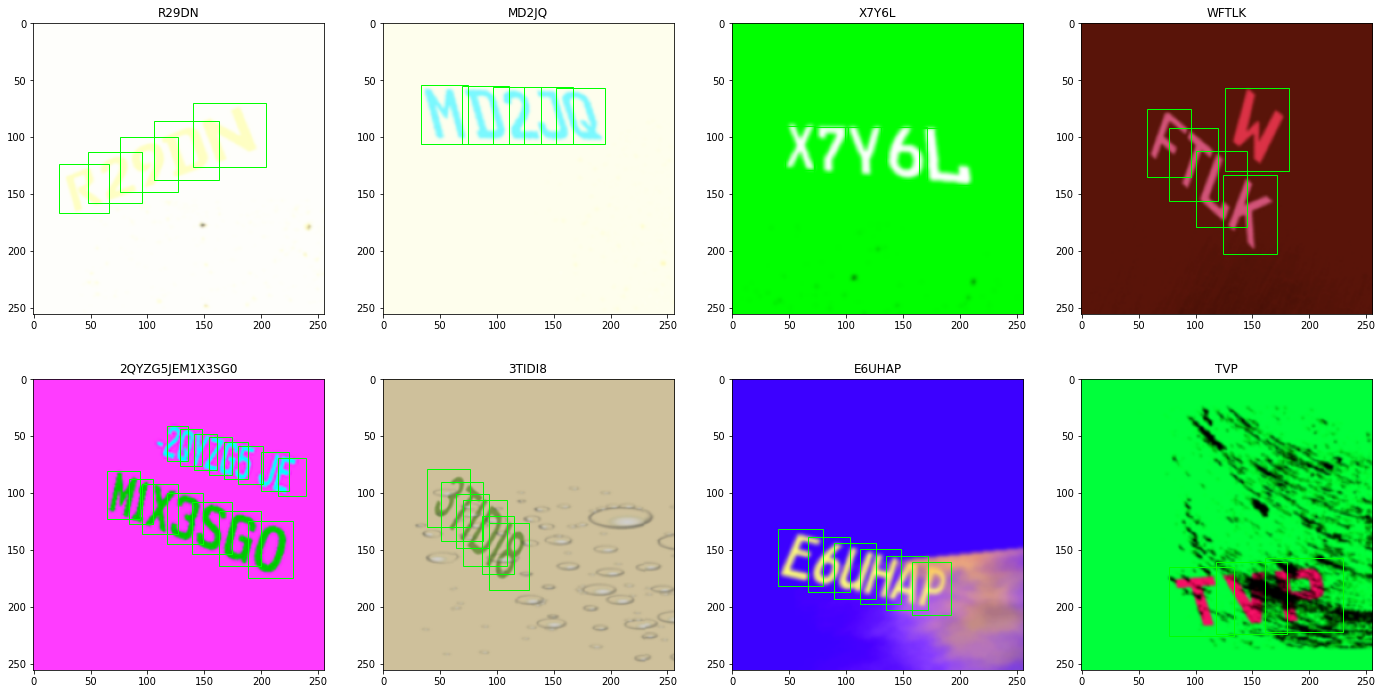

In [ ]:
show_dataset_sample(train, show_boxes=True)

###Inference

In [ ]:
def show_inference(image, boxes, classes, scores, figsize=(7, 7), linewidth=1, box_color="#00ff00"):
    '''Visualize image inference.

    Arguments:
        image: input image on which inference has been done.
        boxes: tensor with shape (N, 4). Each box is in [x_min, y_min, x_max, y_max].
        classes: tensor with shape (N, 1).
        scores: tensor with shape (N, 1).

    Returns:
        Figure with the image and inference results.
    '''
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(image)
    ax = plt.gca()

    img_w = image.shape[1]
    img_h = image.shape[0]
    img_channels = image.shape[2]

    for box, pred_class, score in zip(boxes, classes, scores):
        text = f"{pred_class} | {score*100}%"
        x_min, y_min, x_max, y_max = box
        x_min *= img_w
        x_max *= img_w
        y_min *= img_h
        y_max *= img_h
        bb_width = x_max - x_min
        bb_height = y_max - y_min
        bb_rectangle = plt.Rectangle([x_min, y_min], bb_width, bb_height, fill=False, edgecolor=box_color, linewidth=linewidth)
        ax.add_patch(bb_rectangle)
        ax.text(x_min, y_min, text, bbox={"facecolor": box_color, "alpha": 0.5}, clip_box=ax.clipbox, clip_on=True)
    
    plt.show()

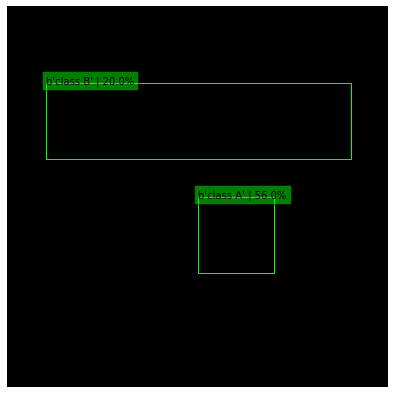

In [ ]:
image = tf.constant(0, shape=(224, 224, 3))
boxes = tf.constant([[0.5, 0.5, 0.7, 0.7], [0.1, 0.2, 0.9, 0.4]])
classes = tf.constant(["class A", "class B"])
scores = tf.constant([0.56, 0.2])
show_inference(image, boxes, classes, scores)

#5. Object Detector utils
> This implementation uses the Keras library to implement object detection. The source code is partially based on https://keras.io/examples/vision/retinanet/.

## Bounding Box converter

In [ ]:
class BoundingBoxConverter:
    """Bounding Box converter class.
    """
    def __init__(self):
        pass

    def convert_to_center(self, corner_boxes):
        '''Convert bounding boxes to [center_x, center_y, width, height] format.

        Arguments:
            corner_boxes: tensor with shape (None, N, 4). Each box is in [x_min, y_min, x_max, y_max].

        Returns:
            Converted boxes in [center_x, center_y, width, height] format.
        '''
        boxes = tf.concat([(corner_boxes[..., :2] + corner_boxes[..., 2:]) / 2.0, corner_boxes[..., 2:] - corner_boxes[..., :2]], axis=-1)
        return boxes

    def convert_to_corners(self, center_boxes):
        '''Convert bounding boxes to [x_min, y_min, x_max, y_max] format.

        Arguments:
            center_boxes: tensor with shape (None, N, 4). Each box is in [center_x, center_y, width, height]

        Returns:
            Converted boxes in [x_min, y_min, x_max, y_max] format.
        '''
        boxes = tf.concat([center_boxes[..., :2] - center_boxes[..., 2:] / 2.0, center_boxes[..., :2] + center_boxes[..., 2:] / 2.0], axis=-1)
        return boxes

    def convert_to_ratio(self, img_dims, px_boxes):
        ratio_boxes = tf.stack([px_boxes[..., 0]/img_dims[0], px_boxes[..., 1]/img_dims[1], px_boxes[..., 2]/img_dims[0], px_boxes[..., 3]/img_dims[1]], axis=-1)
        return ratio_boxes

    def convert_to_px(self, img_dims, ratio_boxes):
        px_boxes = tf.stack([ratio_boxes[..., 0]*img_dims[0], ratio_boxes[..., 1]*img_dims[1], ratio_boxes[..., 2]*img_dims[0], ratio_boxes[..., 3]*img_dims[1]], axis=-1)
        return px_boxes

    def swap_xy(self, boxes):
        '''Swap X and Y coordinates of the input boxes.

        Arguments:
            boxes: tensor with shape (N, 4)

        Returns:
            Swapped boxes.
        '''
        boxes = tf.stack([boxes[..., 1], boxes[..., 0], boxes[..., 3], boxes[..., 2]], axis=-1)
        return boxes

In [ ]:
bb_converter = BoundingBoxConverter()

corner_bbs = tf.constant([[25., 25., 50., 50.], [0., 0., 100., 100.]])
print(corner_bbs)
center_bbs = bb_converter.convert_to_center(corner_bbs)
print(center_bbs)
swapped_corner_bbs = bb_converter.swap_xy(center_bbs)
print(swapped_corner_bbs)
swapped_corner_bbs = bb_converter.swap_xy(swapped_corner_bbs)
print(swapped_corner_bbs)
original_bbs = bb_converter.convert_to_corners(swapped_corner_bbs)
print(original_bbs)
ratio_bbs = bb_converter.convert_to_ratio((100,200), original_bbs)
print(ratio_bbs)
px_bbs = bb_converter.convert_to_px((100,200), ratio_bbs)
print(px_bbs)

tf.Tensor(
[[ 25.  25.  50.  50.]
 [  0.   0. 100. 100.]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[ 37.5  37.5  25.   25. ]
 [ 50.   50.  100.  100. ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[ 37.5  37.5  25.   25. ]
 [ 50.   50.  100.  100. ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[ 37.5  37.5  25.   25. ]
 [ 50.   50.  100.  100. ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[ 25.  25.  50.  50.]
 [  0.   0. 100. 100.]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[0.25  0.125 0.5   0.25 ]
 [0.    0.    1.    0.5  ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[ 25.  25.  50.  50.]
 [  0.   0. 100. 100.]], shape=(2, 4), dtype=float32)


## Detector encoder

In [ ]:
class DetectorEncoder:
    """Detector encoder class.
    """
    def __init__(self):
        self.bb_converter = BoundingBoxConverter()

    def encode_image(self, int_image):
        """Encodes image for a single sample.
        """
        # Only one image, numpy image to tensor, convert [0..255] -> [-1..1]
        float_image = (tf.cast(int_image, dtype=tf.float32) - 127.5) / 127.5
        return float_image

    def decode_image(self, float_image):
        """Decodes image for a single sample.
        """
        # Only one image, tensor to numpy image, convert [-1..1] -> [0..255]
        int_image = np.array(((float_image * 127.5) + 127.5), dtype="int32")
        return int_image

    def encode_classes(self, int_class_IDs):
        """Negative class IDs (unknown char, empty char) are going to be mapped to empty one-hot vectors in the loss function
        """
        float_class_IDs = tf.cast(int_class_IDs, dtype=tf.float32)
        return float_class_IDs

    def decode_classes(self, float_one_hot_class_IDs):
        """Empty one-hot vectors (all values are 0s) are mapped to class ID -1
        """
        non_zeros = tf.math.count_nonzero(float_one_hot_class_IDs, axis=-1, dtype=tf.int32)
        # indices where there is no target class
        empty_value_indices = tf.where(tf.equal(non_zeros, 0))
        # convert to one-hot
        int_class_IDs = tf.argmax(float_one_hot_class_IDs, axis=-1, output_type=tf.int32)
        if(not tf.equal(tf.size(empty_value_indices), 0)):
            # where there was no target class, set the label to -1
            int_class_IDs = tf.tensor_scatter_nd_update(int_class_IDs, empty_value_indices, [-1])
        return int_class_IDs

    def encode_boxes(self, img_dims:(int, int), ratio_corner_boxes):
        # ratio to pixel
        px_corner_boxes = self.bb_converter.convert_to_px(img_dims, ratio_corner_boxes)
        # corner to center
        px_center_boxes = self.bb_converter.convert_to_center(px_corner_boxes)
        return px_center_boxes

    def decode_boxes(self, img_dims:(int, int), px_center_boxes):
        # center to corner
        px_corner_boxes = self.bb_converter.convert_to_corners(px_center_boxes)
        # pixel to ratio
        ratio_corner_boxes = self.bb_converter.convert_to_ratio(img_dims, px_corner_boxes)
        return ratio_corner_boxes

    def encode_detector_raw_boxes(self, anchor_boxes, center_matched_gt_boxes, box_variance):
        """Transforms the ground truth boxes with anchor boxes into targets for training.
        """
        raw_boxes = tf.concat([(center_matched_gt_boxes[..., :2] - anchor_boxes[..., :2]) / anchor_boxes[..., 2:],
             tf.math.log(center_matched_gt_boxes[..., 2:] / anchor_boxes[..., 2:]),], axis=-1,)
        raw_boxes = raw_boxes / box_variance
        return raw_boxes

    def decode_detector_raw_boxes(self, anchor_boxes, raw_boxes, box_variance):
        """Transforms the raw predicted boxes with anchor boxes into center boxes.
        """
        center_matched_gt_boxes = raw_boxes * box_variance
        # generate center boxes from predictions and with anchor boxes
        center_matched_gt_boxes = tf.concat([center_matched_gt_boxes[..., :2] * anchor_boxes[..., 2:] + anchor_boxes[..., :2],
            tf.math.exp(center_matched_gt_boxes[..., 2:]) * anchor_boxes[..., 2:],], axis=-1,)
        return center_matched_gt_boxes

In [ ]:
detector_encoder = DetectorEncoder()

num_classes = 10
int_class_IDs = tf.constant([0, 0, -1, 1, 2])
print(int_class_IDs)
encoded_classes = detector_encoder.encode_classes(int_class_IDs)
print(encoded_classes)

encoded_classes = tf.constant([[0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0]])
print(encoded_classes)
decoded_classes = detector_encoder.decode_classes(encoded_classes)
print(decoded_classes)

ratio_corner_boxes = tf.constant([[0.25, 0.2, 0.5, 0.8], [0.1, 0.1, 0.9, 1.0]])
print(ratio_corner_boxes)
encoded_boxes = detector_encoder.encode_boxes((100, 200), ratio_corner_boxes)
print(encoded_boxes)
decoded_boxes = detector_encoder.decode_boxes((100,200), encoded_boxes)
print(decoded_boxes)

tf.Tensor([ 0  0 -1  1  2], shape=(5,), dtype=int32)
tf.Tensor([ 0.  0. -1.  1.  2.], shape=(5,), dtype=float32)
tf.Tensor(
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]], shape=(2, 5), dtype=float32)
tf.Tensor([3 0], shape=(2,), dtype=int32)
tf.Tensor(
[[0.25 0.2  0.5  0.8 ]
 [0.1  0.1  0.9  1.  ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[ 37.5 100.   25.  120. ]
 [ 50.  110.   80.  180. ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[0.25 0.2  0.5  0.8 ]
 [0.1  0.1  0.9  1.  ]], shape=(2, 4), dtype=float32)


In [ ]:
detector_encoder = DetectorEncoder()

anchor_boxes = tf.constant(([[[0.5,0.5,0.5,0.5],[0.1,0.1,0.1,0.1]]]), dtype="float32")
boxes = tf.constant(([[[1.,1.,1.,1.],[2.,2.,2.,2.]]]), dtype="float32")
box_variance = tf.constant(([0.1, 0.1, 0.2, 0.2]), dtype="float32")
print(boxes)

raw_boxes = detector_encoder.encode_detector_raw_boxes(anchor_boxes, boxes, box_variance)
print(raw_boxes)

boxes = detector_encoder.decode_detector_raw_boxes(anchor_boxes, raw_boxes, box_variance)
print(boxes)

tf.Tensor(
[[[1. 1. 1. 1.]
  [2. 2. 2. 2.]]], shape=(1, 2, 4), dtype=float32)
tf.Tensor(
[[[ 10.        10.         3.465736   3.465736]
  [190.       190.        14.978662  14.978662]]], shape=(1, 2, 4), dtype=float32)
tf.Tensor(
[[[1.        1.        1.        1.       ]
  [2.        2.        2.0000002 2.0000002]]], shape=(1, 2, 4), dtype=float32)


In [ ]:
anchor_boxes = tf.constant([[
    [2., 2., 11.313708, 22.627417],
    [2., 2., 14.254379, 28.508759],
    [96., 96., 456.14014, 228.07007 ],
    [96., 96., 574.70056, 287.35028 ],
]])
raw_boxes = tf.constant([[
    [10., 10., 10., 10.],
    [10., 10., 10., 10.],
    [10., 10., 10., 10.],
    [10., 10., 10., 10.],
]])
box_variance = tf.constant([0.1, 0.1, 0.2, 0.2])

detector_encoder = DetectorEncoder()
detector_encoder.decode_detector_raw_boxes(anchor_boxes, raw_boxes, box_variance)

<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[  13.313708,   24.627417,   83.597626,  167.19525 ],
        [  16.25438 ,   30.508759,  105.32641 ,  210.65282 ],
        [ 552.14014 ,  324.07007 , 3370.445   , 1685.2225  ],
        [ 670.70056 ,  383.35028 , 4246.4946  , 2123.2473  ]]],
      dtype=float32)>

## Intersection over Union (IoU)

In [ ]:
def calculate_IoUs(boxes_a, boxes_b):
    '''Calculate the IoU matrix of the two input bb sets.

    Arguments:
        boxes_a: tensor with shape (N, 4). Each box is in [center_x, center_y, width, height]
        boxes_b: tensor with shape (M, 4). Each box is in [center_x, center_y, width, height]

    Returns:
        IoU matrix of shape (N, M). Matrix[i][j] contains the IoU value between the ith box (from boxes_a) and the jth box (from boxes_b).
    '''
    bb_converter = BoundingBoxConverter()
    # coordinates of bounding boxes
    corner_boxes_a = bb_converter.convert_to_corners(boxes_a)
    corner_boxes_b = bb_converter.convert_to_corners(boxes_b)

    left_ups = tf.maximum(corner_boxes_a[..., None, :2], corner_boxes_b[..., :2])
    right_downs = tf.minimum(corner_boxes_a[..., None, 2:], corner_boxes_b[..., 2:])
    intersections = tf.maximum(0.0, right_downs - left_ups)
    intersection_areas = intersections[..., 0] * intersections[..., 1]

    areas_boxes_a = boxes_a[..., 2] * boxes_a[..., 3]
    areas_boxes_b = boxes_b[..., 2] * boxes_b[..., 3]
    epsilon=1e-16
    union_areas = tf.maximum(areas_boxes_a[..., None] + areas_boxes_b - intersection_areas, epsilon)
    
    return tf.clip_by_value(intersection_areas / union_areas, 0.0, 1.0)

In [ ]:
xywh_bbs_a = tf.constant([[[5, 5, 2, 2], [3.5, 3.5, 1, 2]]])
xywh_bbs_b = tf.constant([[[5, 5, 2, 2], [3.5, 3.5, 1, 2], [6, 6, 0.5, 0.6]]])
IoUs = calculate_IoUs(xywh_bbs_a, xywh_bbs_b)
print(IoUs)

tf.Tensor(
[[[1.         0.         0.01775149]
  [0.         1.         0.        ]]], shape=(1, 2, 3), dtype=float32)


## Anchor box generation
> Pre-defined, fix sized boxes that the model uses to predict bounding boxes for objects. Anchor boxes are used the following way:
- the model regresses an offset between the object's center and the anchor box's center
- then anchor box width and height is used to predict a relative scale of the object

In [ ]:
class AnchorBox:
    '''Anchor box generator.

    Generates anchor boxes for feature maps between strides [2^start, 2^end). 
    Each anchor box has the format [center_x, center_y, width, height].

    Attributes:
        aspect_ratios: list of double values representing the aspect ratios of the anchor boxes at each feature map location.
        scales: list of double values representing the scales of the anchor boxes at each feature map location.
        num_anchors: number of anchor boxes at each feature map location.
        areas: list of doubles representing the areas of the anchor boxes for each feature map in the feature pyramid.
        strides: A list of float value representing the strides for each feature map in the feature pyramid.
    '''
    # area_ratios must be the list of values of the last N output feature maps
    # strides must be the list of the corresponding area_ratio/4
    
    def __init__(self, aspect_ratios=[0.5, 1.0, 2.0], scale_ratios=[0, 1/3, 2/3], area_ratios=[16., 32., 64., 128., 256.], strides=[4, 8, 16, 32, 64]):
        self.aspect_ratios = aspect_ratios
        self.scales = [2 ** x for x in scale_ratios]
        self.num_anchors = len(self.aspect_ratios) * len(self.scales)
        self.areas = [x ** 2 for x in area_ratios]
        self.strides = strides
        self.anchor_dims = self.calculate_anchor_dims()

    def calculate_anchor_dims(self):
        '''Calculates anchor box dimensions for all ratios and scales at all levels of the feature pyramid.
        '''
        all_anchor_dims = []
        for area in self.areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2])
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            all_anchor_dims.append(tf.stack(anchor_dims, axis=-2))
        return all_anchor_dims

    def generate_level_anchors(self, feature_height, feature_width, level):
        '''Generate anchor boxes for a feature map size and level.

        Arguments:
            feature_height: height of the current feature map.
            feature_width: width of the current feature map.
            level: An integer representing the level of the feature map in the feature pyramid.

        Returns:
            Anchor boxes of the current level with shape (feature_height * feature_width * num_anchors, 4).
        '''
        range_x = tf.range(feature_width, dtype=tf.float32) + 0.5
        range_y = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(range_x, range_y), axis=-1) * self.strides[level]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self.num_anchors, 1])
        dims = tf.tile(self.anchor_dims[level], [feature_height, feature_width, 1, 1])
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(anchors, [feature_height * feature_width * self.num_anchors, 4])

    def get_anchors(self, img_shape):
        '''Generate anchor boxes for all feature maps in the feature pyramid.

        Arguments:
            img_shape: image dimensions (height, width).

        Returns:
            Anchor boxes for all feature maps, stacked as a single tensor with shape (total_anchors, 4).
        '''
        anchors = [self.generate_level_anchors(tf.math.ceil(img_shape[0] / self.strides[i]), 
                                               tf.math.ceil(img_shape[1] / self.strides[i]), 
                                               i) for i in range(len(self.strides))]
        # stack as a single tensor
        anchors = tf.concat(anchors, axis=0)
        return tf.expand_dims(anchors, axis=0)

In [ ]:
anchors = AnchorBox()
anchors.get_anchors((256, 256))

<tf.Tensor: shape=(1, 49104, 4), dtype=float32, numpy=
array([[[  2.      ,   2.      ,  11.313708,  22.627417],
        [  2.      ,   2.      ,  14.254379,  28.508759],
        [  2.      ,   2.      ,  17.959393,  35.918785],
        ...,
        [224.      , 224.      , 362.03867 , 181.01933 ],
        [224.      , 224.      , 456.14014 , 228.07007 ],
        [224.      , 224.      , 574.70056 , 287.35028 ]]], dtype=float32)>

## Detector training encoder
> Raw labels consisting images, bounding boxes and class IDs need to be transformed into targets for training. The steps are the following:
- Generate anchor boxes for the given image dimensions
- Assign ground truth boxes to the anchor boxes
- Anchor boxes that are not assigned to any objects are assigned to the background class (or ignored depending on the IoU)
- Generate classification and regression targets using anchor boxes

In [ ]:
class DetectorTrainingEncoder:
    """Transforms the raw labels into targets for training.

    This class has operations to generate targets for a batch of samples which is made up of the input images, bounding boxes for the objects and their class IDs.

    Attributes:
        detector_encoder: Detector encoder.
        anchor_box: Anchor box generator to encode the bounding boxes.
        box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self, image_shape):
        self.detector_encoder = DetectorEncoder()
        self.anchor_box = AnchorBox()
        self.box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)

    def match_anchor_boxes(self, anchor_boxes, ground_truth_boxes, match_IoU_thres=0.5, ignore_IoU_thres=0.4):
        """Matches ground truth boxes to anchor boxes based on IoU.

        Arguments:
            anchor_boxes: A float tensor with the shape (total_anchors, 4) representing all the anchor boxes for a given input image shape. Each anchor box is of the format [center_x, center_y, width, height].
            ground_truth_boxes: A float tensor with shape (num_objects, 4) representing the ground truth boxes, where each box is of the format [center_x, center_y, width, height].
            match_IoU_thres: A float value representing the minimum IoU threshold for determining if a ground truth box can be assigned to an anchor box.
            ignore_IoU_thres: A float value representing the IoU threshold under which an anchor box is assigned to the background class.

        Returns:
            matched_gt_indices: Indices of the matched objects.
            positive_mask: A mask for anchor boxes that have been assigned to the ground truth boxes.
            ignore_mask: A mask for anchor boxes that need to be ignored during training.
        """
        # Calculate the pairwise IoU for the M anchor_boxes and N ground_truth_boxes to get an (M, N) shaped matrix
        IoU_matrix = calculate_IoUs(anchor_boxes, ground_truth_boxes)
        # max IoU value for each anchor box
        max_IoU = tf.reduce_max(IoU_matrix, axis=-1)
        # max IoU index for each anchor box
        matched_gt_indices = tf.argmax(IoU_matrix, axis=-1)
        # the ground truth box with the maximum IoU for each anchor box is assigned, if the IoU is greater than match_IoU_thres
        positive_mask = tf.greater_equal(max_IoU, match_IoU_thres)
        # if the maximum IoU for an anchor box is less than ignore_IoU_thres, the anchor box is assigned to the negative mask (background class)
        negative_mask = tf.less(max_IoU, ignore_IoU_thres)
        # the remaining anchor boxes that do not have any ground truth assigned are ignored during training
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        # boolean to float
        positive_mask = tf.cast(positive_mask, dtype=tf.float32)
        ignore_mask = tf.cast(ignore_mask, dtype=tf.float32)
        return matched_gt_indices, positive_mask, ignore_mask

    def target_encoder(self, image_shape, gt_boxes, class_IDs):
        """Creates box and class targets for a single sample.
        """
        #print(f"gt_boxes:{gt_boxes.shape}\n{gt_boxes}\n")
        #print(f"class_IDs:{class_IDs.shape}\n{class_IDs}\n")
        # generate anchor boxes (center boxes)
        anchor_boxes = self.anchor_box.get_anchors(image_shape)
        #print(f"anchor_boxes:{anchor_boxes.shape}\n{anchor_boxes}\n")
        matched_gt_indices, positive_mask, ignore_mask = self.match_anchor_boxes(anchor_boxes, gt_boxes)
        #print(f"matched_gt_indices:{matched_gt_indices.shape}\n{matched_gt_indices}")
        #print(f"positive_mask:{positive_mask.shape}\n{positive_mask}\n")
        #print(f"ignore_mask:{ignore_mask.shape}\n{ignore_mask}\n")
        # gather matched boxes from ground truth boxes according to matched indices
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_indices)
        #print(f"matched_gt_boxes:{matched_gt_boxes.shape}\n{matched_gt_boxes}\n")
        # encode box target
        box_target = self.detector_encoder.encode_detector_raw_boxes(anchor_boxes, matched_gt_boxes, self.box_variance)
        #print(f"box_target:{box_target.shape}\n{box_target}\n")
        # gather matched class IDs from class IDs according to matched indices
        matched_gt_class_IDs = tf.gather(class_IDs, matched_gt_indices)
        #print(f"matched_gt_class_IDs:{matched_gt_class_IDs.shape}\n{matched_gt_class_IDs}\n")
        # if not in positive mask (no match), -1.0 (background class); otherwise, set the corresponding class ID
        class_target = tf.where(tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_class_IDs)
        #print(f"class_target:{class_target.shape}\n{class_target}\n")
        # if in the ignore mask, -2.0 (ignore completely)
        class_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, class_target)
        #print(f"class_target:{class_target.shape}\n{class_target}\n")
        # insert a length 1 axis to the last axis
        class_target = tf.expand_dims(class_target, axis=-1)
        #print(f"class_target:{class_target.shape}\n{class_target}\n")
        # concatenate box (regression) and class (classification) targets along the last axis
        label = tf.concat([box_target, class_target], axis=-1)
        #print(f"label:{label.shape}\n{label}\n")
        return label

    def encode_batch(self, batch_images, batch_gt_boxes, batch_class_IDs):
        """Creates box (regression) and class (classification) targets for one batch.
        """
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        images = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)

        for i in range(batch_size):
            # encoders
            # int [0..255] to float [-1..1]
            image = self.detector_encoder.encode_image(batch_images[i])
            # ratios to pixel values, then corner boxes to center boxes
            boxes = self.detector_encoder.encode_boxes(tf.cast(images_shape[1:3], dtype=tf.float32), batch_gt_boxes[i])
            # int IDs to float IDs
            classes = self.detector_encoder.encode_classes(batch_class_IDs[i])
            # build targets
            label = self.target_encoder(images_shape[1:3], boxes, classes)
            label = tf.squeeze(label)
            # save
            images = images.write(i, image)
            labels = labels.write(i, label)

        # stack the list of rank-R tensors into one rank-(R+1) tensor (both for images and labels)
        return images.stack(), labels.stack()

    def data_to_input(self, image, label):
        # Return a dict
        #return {"image": image, "label": tf.expand_dims(label, axis=-1)}
        return image, label

##Detector specific datasets

In [ ]:
num_classes = len(train.label_characters)
img_shape = (img_h, img_w)

autotune = tf.data.AUTOTUNE
training_encoder = DetectorTrainingEncoder(img_shape)
train_dataset = train.dataset.map(lambda image, boxes, labels : tf.py_function(func=training_encoder.encode_batch, inp=[image, boxes, labels], Tout=[tf.float32, tf.float32]), num_parallel_calls=autotune).map(training_encoder.data_to_input)
validation_dataset = validation.dataset.map(lambda image, boxes, labels : tf.py_function(func=training_encoder.encode_batch, inp=[image, boxes, labels], Tout=[tf.float32, tf.float32]), num_parallel_calls=autotune).map(training_encoder.data_to_input)

In [ ]:
train_steps_per_epoch = train_dataset.cardinality().numpy()
val_steps_per_epoch = train_dataset.cardinality().numpy()
print(f"Train dataset steps per epoch: {train_steps_per_epoch}")
print(f"Validation dataset steps per epoch: {val_steps_per_epoch}")

Train dataset steps per epoch: 1250
Validation dataset steps per epoch: 1250


(8, 256, 256, 3)
(8, 49104, 5)

One image
Boxes: [[ 2.2097086e+01  6.0546021e+01  2.3217833e+00  6.9467133e-01]
 [ 1.7538469e+01  4.8055405e+01  1.1665379e+00 -4.6057415e-01]
 [ 1.3920293e+01  3.8141602e+01  1.1292451e-02 -1.6158195e+00]
 ...
 [-4.4884706e+00 -5.1651940e+00 -1.4736561e+01 -9.5138350e+00]
 [-3.9461555e+00 -3.9242327e+00 -1.4723731e+01 -1.0669080e+01]
 [-6.3511336e-01 -4.2804899e+00 -1.5290061e+01 -1.1297523e+01]]
Classes: [-1. -1. -1. ... -1. -1. -1.]
Unique classes: UniqueWithCounts(y=<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([-1., -2., 10.,  9., 20., 15.,  8.,  0., 11., 19., 23.],
      dtype=float32)>, idx=<tf.Tensor: shape=(49104,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>, count=<tf.Tensor: shape=(11,), dtype=int32, numpy=
array([48112,   662,    31,    65,    43,    32,    31,    32,    35,
          32,    29], dtype=int32)>)


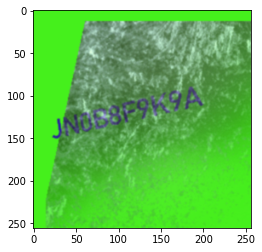

In [ ]:
for images, labels in train_dataset.take(1):
    #images = batch['image']
    #labels = batch['label']
    print(images.shape)
    print(labels.shape)
    # one image sample
    image = images[0]
    image_boxes = labels[0, :, :4]
    image_classes = labels[0, :, 4]
    print("\nOne image")
    print(f"Boxes: {image_boxes}")
    print(f"Classes: {image_classes}")
    print(f"Unique classes: {tf.unique_with_counts(image_classes)}")
    # -1..1 to 0..1 on the fly
    plt.imshow((image+1)/2)
    # explicitly free objects
    del images
    del labels
    del image_boxes
    del image_classes
    gc.collect()

#6. Model creation

## MISC: custom layers and blocks

###RetinaNet loss layer
>Used at the end of the network to calculate RetinaNet loss.

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Smooth L1 loss
    """
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(reduction="none", name="RetinaNetBoxLoss")
        self.delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        abs_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(tf.less(abs_difference, self.delta), 0.5 * squared_difference, abs_difference - 0.5)
        # sum along the last axis
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetClassificationLoss(tf.losses.Loss):
    """Focal loss
    """
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(reduction="none", name="RetinaNetClassificationLoss")
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        """ Binary Cross-Entropy loss (also called Sigmoid Cross-Entropy). It is a Sigmoid activation plus a Cross-Entropy loss. Unlike Softmax loss it is independent for each vector component (class), 
            meaning that the loss computed for every CNN output vector component is not affected by other component values. That is why it is used for multi-label classification, 
            where the insight of an element belonging to a certain class should not influence the decision for another class. It is faster than multi-class Cross Entropy.
            It is called Binary Cross-Entropy loss because it sets up a binary classification problem between C=2 classes for every class in C, as explained above.
            This loss is helpful to avoid exponential overflow.
        """
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probabilities = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self.alpha, (1.0 - self.alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probabilities, 1 - probabilities)
        loss = alpha * tf.pow(1.0 - pt, self.gamma) * cross_entropy
        # sum along the last axis
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetLoss(tf.losses.Loss):
    """The RetinaNet loss function contains Smooth L1 loss and Focal loss combined.
    """
    # original parameters: alpha=0.25, gamma=2.0, delta=1.0
    def __init__(self, num_classes, alpha=0.85, gamma=1.2, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self.num_classes = num_classes
        self.box_loss = RetinaNetBoxLoss(delta)
        self.class_loss = RetinaNetClassificationLoss(alpha, gamma)

    def call(self, y_true, y_pred):
        """ y_true: tf.tensor with shape (batch_size, num_samples, 5), where [][][:4] are the box labels and [][][4] is the class ID; dtype=float32
            y_pred: tf.tensor with shape (batch_size, num_samples, 4+num_classes), where [][][:4] are the box labels and from [][][4:] is the one-hot encoded class; dtype=float32
        """
        #tf.print(tf.shape(y_true))
        #tf.print(tf.shape(y_pred))
        # boxes
        box_targets = y_true[..., :4]
        box_predictions = y_pred[..., :4]
        # classes
        # one-hot encode class targets
        one_hot_class_targets = tf.one_hot(
            tf.cast(y_true[..., 4], dtype=tf.int32),
            depth = self.num_classes,
            dtype=tf.float32,
        )
        class_predictions = y_pred[..., 4:]
        # masks for loss calculations
        positive_mask = tf.cast(tf.greater(y_true[..., 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[..., 4], -2.0), dtype=tf.float32)
        # box loss
        box_loss = self.box_loss(box_targets, box_predictions)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        # classification loss
        class_loss = self.class_loss(one_hot_class_targets, class_predictions)
        class_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, class_loss)
        # loss normalization
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        class_loss = tf.math.divide_no_nan(tf.reduce_sum(class_loss, axis=-1), normalizer)
        # total loss
        total_loss = (0.6*box_loss) + class_loss
        return total_loss

In [ ]:
# shape: batch_size x num_objects x 5
true = tf.constant(([
                     [[10.,10.,10.,10., 2.],[10.,10.,10.,10., 1.]],
                     [[10.,10.,10.,10., 2.],[10.,10.,10.,10., 1.]]
                     ]), dtype="float32")
# shape: batch_size x num_objects x (4 + num_classes)
pred = tf.constant(([
                     [[10.,10.,10.,10., 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],[10.,10.,10.,10., 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]],
                     [[10.,10.,10.,10., 0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],[10.,10.,10.,10., 0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]]
                     ]), dtype="float32")

print(true)
print(pred)

loss = RetinaNetLoss(35)
print(loss.call(true, pred))

tf.Tensor(
[[[10. 10. 10. 10.  2.]
  [10. 10. 10. 10.  1.]]

 [[10. 10. 10. 10.  2.]
  [10. 10. 10. 10.  1.]]], shape=(2, 2, 5), dtype=float32)
tf.Tensor(
[[[10. 10. 10. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.]
  [10. 10. 10. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.]]

 [[10. 10. 10. 10.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.]
  [10. 10. 10. 10.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.]]], shape=(2, 2, 39), dtype=float32)
tf.Tensor([1.7951736 1.5937903], shape=(2,), dtype=float32)


In [ ]:
class RetinaNetLossLayer(layers.Layer):
    
    def __init__(self, num_classes, name=None):
        super(RetinaNetLossLayer, self).__init__(name=name)
        self.loss_fn = RetinaNetLoss(num_classes)

    def call(self, y_true, y_pred, sample_weight=None):
        '''
        y_true: tf.tensor with shape (batch_size, num_samples, 5), where [][][:4] are the box labels and [][][4] is the class ID; dtype=float32
        y_pred: tf.tensor with shape (batch_size, num_samples, 4+num_classes), where [][][:4] are the box labels and from [][][4:] is the one-hot encoded class; dtype=float32
        '''
        y_pred = tf.cast(y_pred, dtype="float32")
        y_true = tf.cast(y_true, dtype="float32")
        loss = self.loss_fn(y_true, y_pred)
        print(f"loss:{loss.shape}\n{loss}\n")
        # Add loss to the parent layer
        #self.add_loss(lambda loss: self.loss_fn)
        self.add_loss(lambda: loss)

        # At inference, just return the model predictions
        return y_pred

In [ ]:
# shape: batch_size x num_objects x 5
true = tf.constant(([[[10.,10.,10.,10., 2.],[10.,10.,10.,10., 1.]]]), dtype="float32")
# shape: batch_size x num_objects x (4 + num_classes)
pred = tf.constant(([[[10.,10.,10.,10., 0.,0.,1.],[10.,10.,10.,10., 0.,1.,0.]]]), dtype="float32")

print(true)
print(pred)

loss_layer = RetinaNetLossLayer(3)
loss_layer.call(true, pred)

tf.Tensor(
[[[10. 10. 10. 10.  2.]
  [10. 10. 10. 10.  1.]]], shape=(1, 2, 5), dtype=float32)
tf.Tensor(
[[[10. 10. 10. 10.  0.  0.  1.]
  [10. 10. 10. 10.  0.  1.  0.]]], shape=(1, 2, 7), dtype=float32)
loss:()
0.14558301866054535



<tf.Tensor: shape=(1, 2, 7), dtype=float32, numpy=
array([[[10., 10., 10., 10.,  0.,  0.,  1.],
        [10., 10., 10., 10.,  0.,  1.,  0.]]], dtype=float32)>

### Output decoder layer

In [ ]:
class OutputDecoder(layers.Layer):
    """Keras layer that decodes predictions of the object detector.

    Attributes:
        num_classes: Number of possible output classes.
        confidence_thres: Minimum class probability, below which detections are pruned.
        nms_IoU_thres: IoU threshold for the NMS operation.
        max_detections_per_class: Maximum number of detections to retain per class.
        max_detections: Maximum number of detections to retain across all classes.
        box_variance: Scaling factors used to scale bounding box predictions.
    """
    def __init__(self, confidence_thres=0.05, nms_IoU_thres=0.5, max_detections_per_class=100, max_detections=100, box_variance=[0.1, 0.1, 0.2, 0.2], **kwargs):
        super(OutputDecoder, self).__init__(**kwargs)
        self.confidence_thres = confidence_thres
        self.nms_IoU_thres = nms_IoU_thres
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self.detector_encoder = DetectorEncoder()
        self.anchor_box = AnchorBox()
        self.box_variance = tf.convert_to_tensor(box_variance, dtype=tf.float32)

    def call(self, inputs, predictions):
        input_shape = tf.cast(tf.shape(inputs), dtype=tf.float32)
        anchor_boxes = self.anchor_box.get_anchors(input_shape[1:3])
        box_predictions = predictions[..., :4]
        class_predictions = tf.nn.sigmoid(predictions[..., 4:])
        px_center_boxes = self.detector_encoder.decode_detector_raw_boxes(anchor_boxes, box_predictions, self.box_variance)
        ratio_corner_boxes = self.detector_encoder.decode_boxes(input_shape[1:3], px_center_boxes)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(ratio_corner_boxes, axis=2),
            class_predictions, 
            self.max_detections_per_class, 
            self.max_detections, 
            self.nms_IoU_thres, 
            self.confidence_thres, 
            clip_boxes=False,
        )

In [ ]:
out_decoder = OutputDecoder(confidence_thres=0.05, nms_IoU_thres=0.5, max_detections_per_class=10, max_detections=10, name="detections")

image = tf.zeros(shape=[1, 256, 256, 3], dtype="float32")
anchors = out_decoder.anchor_box.get_anchors(image.shape[1:3])
anchors_shape = list(anchors.shape)
anchors_shape[2] += 3
# shape: batch_size x num_objects x (4 + num_classes)
pred = tf.zeros(shape=anchors_shape, dtype="float32")

out_decoder(image, pred)

CombinedNonMaxSuppression(nmsed_boxes=<tf.Tensor: shape=(1, 10, 4), dtype=float32, numpy=
array([[[ 0.20446542, -0.03638167,  0.24865958,  0.05200667],
        [ 0.5234375 ,  0.0234375 ,  0.5859375 ,  0.0859375 ],
        [ 0.72383124, -0.02616878,  0.82304376,  0.07304378],
        [ 0.83861834, -0.01428459,  0.92700666,  0.02990959],
        [ 0.41023555, -0.06234138,  0.48038945,  0.07796638],
        [ 0.20446542, -0.03638167,  0.24865958,  0.05200667],
        [ 0.03140862, -0.02726444,  0.17171638,  0.04288944],
        [ 0.0234375 , -0.0234375 ,  0.0859375 ,  0.0390625 ],
        [-0.03638167, -0.01428459,  0.05200667,  0.02990959],
        [-0.02726444, -0.06234138,  0.04288944,  0.07796638]]],
      dtype=float32)>, nmsed_scores=<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]], dtype=float32)>, nmsed_classes=<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[1., 2., 2., 2., 2., 2., 2., 2., 2., 2.]], dtype=float32)>

### Extended Convolutional layer
>To avoid boilerplate layer chaining, a custom convolutional layer is defined. It contains the following layers: convolution, batch normalization, dropout.

In [ ]:
class Conv(layers.Layer):

    def __init__(self, in_channel, out_channel, kernel_size=3, strides=(1, 1), activation="relu", batchnorm_needed=True, dropout=0.1, kernel_initializer="glorot_uniform", bias_initializer="zeros", name=""):
        super(Conv, self).__init__(name=name)

        # init layers
        self.conv = None
        self.dropout = layers.Dropout(rate=dropout, name=f"{name}_Dropout")
        self.batch_norm = None
        self.activation = None

        # batch normalization
        self.use_bias = True
        if (batchnorm_needed):
            # bias is False, because batch norm already adds a constant
            self.use_bias = False
            self.batch_norm = layers.BatchNormalization(name=f"{name}_BatchNorm")
        else:
            # bias is needed
            self.use_bias = True

        self.conv = layers.Conv2D(filters=out_channel, kernel_size=kernel_size, padding="same", strides=strides, dilation_rate=1, 
                                activation=activation, use_bias=self.use_bias, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, 
                                name=f"{name}_Convolution")
        if(activation != None):
            self.activation = layers.Activation(activation)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.dropout(x)
        if (self.batch_norm != None):
            x = self.batch_norm(x)
        if (self.activation != None):
            x = self.activation(x)
        return x

In [ ]:
conv = Conv(in_channel=3, out_channel=8, kernel_size=3, strides=(1, 1), activation="relu", batchnorm_needed=True, dropout=0.2, name="Conv1")

In [ ]:
y = conv(tf.ones([1, 32, 32, 3]))
print(y)

tf.Tensor(
[[[[9.6057616e-02 0.0000000e+00 0.0000000e+00 ... 3.8302240e-01
    0.0000000e+00 0.0000000e+00]
   [1.9070593e-01 0.0000000e+00 0.0000000e+00 ... 4.6257007e-01
    0.0000000e+00 6.5920430e-01]
   [1.9070593e-01 0.0000000e+00 0.0000000e+00 ... 4.6257007e-01
    0.0000000e+00 6.5920430e-01]
   ...
   [1.9070593e-01 0.0000000e+00 0.0000000e+00 ... 4.6257007e-01
    0.0000000e+00 6.5920430e-01]
   [1.9070593e-01 0.0000000e+00 0.0000000e+00 ... 4.6257007e-01
    0.0000000e+00 6.5920430e-01]
   [3.7633441e-03 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 7.6859915e-01]]

  [[3.1608886e-01 0.0000000e+00 0.0000000e+00 ... 7.1634340e-01
    0.0000000e+00 0.0000000e+00]
   [1.1563849e-01 0.0000000e+00 0.0000000e+00 ... 9.3298131e-01
    0.0000000e+00 1.1426312e+00]
   [1.1563849e-01 0.0000000e+00 0.0000000e+00 ... 9.3298131e-01
    0.0000000e+00 1.1426312e+00]
   ...
   [1.1563849e-01 0.0000000e+00 0.0000000e+00 ... 9.3298131e-01
    0.0000000e+00 1.1426312e+00]
   

### Blur Pool layer
>To make the network shift-invariant (https://arxiv.org/pdf/1904.11486.pdf).

In [ ]:
class BlurPool(layers.Layer):

    def __init__(self, kernel_size=3, strides=(1, 1), padding="same", name="", **kwargs):
        super(BlurPool, self).__init__(name=name, **kwargs)
        self.kernel = None
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.p_name = name
    
    def build(self, input_shape):
        # default kernel
        f = np.array([[1]])
        # choose kernel
        if (self.kernel_size == 1):
            f = np.array([[1.0,]])
        elif (self.kernel_size == 2):
            f = np.array([[1.0, 1.0]])
        elif (self.kernel_size == 3):
            f = np.array([[1.0, 2.0, 1.0]])
        elif (self.kernel_size == 4):    
            f = np.array([[1.0, 3.0, 3.0, 1.0]])
        elif (self.kernel_size == 5):    
            f = np.array([[1.0, 4.0, 6.0, 4.0, 1.0]])
        elif (self.kernel_size == 6):    
            f = np.array([[1.0, 5.0, 10.0, 10.0, 5.0, 1.0]])
        elif (self.kernel_size == 7):    
            f = np.array([[1.0, 6.0, 15.0, 20.0, 15.0, 6.0, 1.0]])
        # form 2D kernel
        f_transposed = f.T
        blur_kernel = f * f_transposed
        blur_kernel = blur_kernel / np.sum(blur_kernel)
        # blur kernels in the number of channels
        blur_kernel = np.repeat(blur_kernel, input_shape[3])
        blur_kernel = np.reshape(blur_kernel, (self.kernel_size, self.kernel_size, input_shape[3], 1))
        blur_init = keras.initializers.constant(blur_kernel)
        # initialize blur kernel
        self.kernel = self.add_weight(name='blur_kernel',
                                      shape=(self.kernel_size, self.kernel_size, input_shape[3], 1),
                                      initializer=blur_init, trainable=False)
        super(BlurPool, self).build(input_shape)

    def call(self, inputs):
        x = keras.backend.depthwise_conv2d(x=inputs, depthwise_kernel=self.kernel, padding=self.padding, strides=self.strides)
        return x

    def compute_output_shape(self, input_shape):
        if (self.padding == "same"):
            # same padding
            return input_shape[0], int(np.ceil(input_shape[1] / self.strides[0])), int(np.ceil(input_shape[2] / self.strides[1])), input_shape[3]
        else:
            # valid padding
            return input_shape[0], int(input_shape[1] / self.strides[0]), int(input_shape[2] / self.strides[1]), input_shape[3]

    def get_config(self):
        base_config = super(BlurPool, self).get_config()
        config = {
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "padding": self.padding,
            "name": self.p_name
        }
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
blurPool = BlurPool(kernel_size=3, strides=(2, 2), padding="same", name="1")

In [ ]:
y = blurPool(tf.ones([1, 10, 10, 3]))
print(y)

tf.Tensor(
[[[[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[0.75   0.75   0.75  ]
   [0.75   0.75   0.75  ]
   [0.75   0.75   0.75  ]
   [0.75   0.75   0.75  ]
   [0.5625 0.5625 0.5625]]]], shape=(1, 5, 5, 3), dtype=float32)


### Residual block
>To avoid the vanishing gradient problem, a block of convolutional layers is defined with skip connecton between its input and its output. That means, the input directly influences the output, not just the conv activations. Number of conv layers in a block can be defined with a parameter. The number of channels are identical in a block, only the last layer of the block does spatial scaling down & channel scaling up (by a factor of 2).

In [ ]:
class Residual_block(layers.Layer):

    def __init__(self, in_channel, out_channel, kernel_size=3, strides=(2, 2), activation="relu", batchnorm_needed=True, dropout=0.1, 
                 num_layers=1, residual_needed=True, name=""):
        super(Residual_block, self).__init__(name=name)
        self.residual_needed = residual_needed
        self.residual_block = keras.Sequential(name=f"{name}_Conv{num_layers}x")
        # num_layers convolutional layers in a residual block
        for i in range(num_layers):
            self.residual_block.add(Conv(in_channel=in_channel, out_channel=in_channel, kernel_size=kernel_size, strides=(1, 1), activation=activation, 
                                         batchnorm_needed=batchnorm_needed, dropout=dropout, name=f"{name}_Conv{i+1}"))
        # channel scaling convolution
        self.channel_scale = Conv(in_channel=in_channel, out_channel=out_channel, kernel_size=kernel_size, strides=(1, 1), activation=activation, 
                                  batchnorm_needed=batchnorm_needed, dropout=dropout, name=f"{name}_ChannelScale")
        # spatial scaling shift invariant pooling layer
        #self.spatial_scale = BlurPool(kernel_size=kernel_size, strides=strides, padding="same", name=f"{name}_SpatialScale")
        self.spatial_scale = layers.MaxPooling2D(strides=strides, padding="same", name=f"{name}_MaxPooling")

    def __call__(self, inputs, training=None):
        result = self.residual_block(inputs)
        # residual connection 
        if (self.residual_needed):
            result += inputs
        result = self.channel_scale(result)
        return self.spatial_scale(result)

In [ ]:
residual_block = Residual_block(in_channel=8, out_channel=16, kernel_size=3, strides=(2, 2), activation="relu", batchnorm_needed=True, dropout=0.2, 
                                num_layers=1, residual_needed=True, name="ResBlock1")

In [ ]:
y = residual_block(tf.ones([1, 32, 32, 8]))
print(y)

tf.Tensor(
[[[[0.         1.5904078  1.377068   ... 0.52878934 0.
    0.88308966]
   [0.         1.5125582  1.3489836  ... 0.5373672  0.
    1.0015879 ]
   [0.         1.5125582  1.3489836  ... 0.5373672  0.
    1.0015879 ]
   ...
   [0.         1.5125582  1.3489836  ... 0.5373672  0.
    1.0015879 ]
   [0.         1.5125582  1.3489836  ... 0.5373672  0.
    1.0015879 ]
   [0.23669703 1.5044022  1.2893484  ... 0.43904862 0.
    0.9821537 ]]

  [[0.         2.1666603  1.2527542  ... 0.4492672  0.25245848
    0.3406251 ]
   [0.         2.124613   1.2131683  ... 0.45146656 0.
    0.45066994]
   [0.         2.124613   1.2131683  ... 0.45146656 0.
    0.45066994]
   ...
   [0.         2.124613   1.2131683  ... 0.45146656 0.
    0.45066994]
   [0.         2.124613   1.2131683  ... 0.45146656 0.
    0.45066994]
   [0.3827423  2.054215   1.2184491  ... 0.3641866  0.14769956
    0.4572974 ]]

  [[0.         2.1666603  1.2527542  ... 0.4492672  0.25245848
    0.3406251 ]
   [0.         2.124613 

### Prediction head
> Separate heads are needed for bounding box regression and class prediction.

In [ ]:
class PredictionHead(layers.Layer):

    def __init__(self, in_channel, out_channel, kernel_size=3, activation="relu", batchnorm_needed=True, dropout=0.0, num_layers=4, kernel_initializer="glorot_uniform", bias_initializer="zeros", name=""):
        super(PredictionHead, self).__init__(name=name)

        self.head = keras.Sequential(name=f"{name}_Conv{num_layers}x")
        # num_layers convolutional layers
        for i in range(num_layers):
            self.head.add(Conv(in_channel, in_channel, kernel_size, (1, 1), activation=activation, batchnorm_needed=batchnorm_needed, 
                               dropout=dropout, kernel_initializer=kernel_initializer, bias_initializer="zeros", name=f"{name}_Conv{i+1}"))
        # last Conv layer outputting a feature map corresponding to out_channel
        self.out = Conv(in_channel, out_channel, kernel_size, (1, 1), activation=None, batchnorm_needed=batchnorm_needed, 
                           dropout=0.0, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, name=f"{name}_ConvOut")

    def __call__(self, input, training=None):
        x = self.head(input)
        x = self.out(x)
        return x

In [ ]:
pred_head = PredictionHead(in_channel=3, out_channel=8, kernel_size=3, activation="relu", batchnorm_needed=True, dropout=0.1, name="PredHead")

In [ ]:
y = pred_head(tf.ones([1, 32, 32, 3]))
print(y)

tf.Tensor(
[[[[-0.14778484  0.00893483  0.15420808 ...  0.14445435 -0.06448881
     0.0803706 ]
   [-0.23787716 -0.06673232  0.28062835 ...  0.19596103 -0.00920144
     0.08180503]
   [-0.21851718 -0.11137602  0.3405471  ...  0.18420762  0.03508778
     0.06177616]
   ...
   [-0.30279252 -0.11719336  0.42609325 ...  0.26633334  0.03435393
     0.12459739]
   [-0.20886521 -0.1511891   0.39055714 ...  0.16812034  0.06882592
     0.03617277]
   [-0.07100067 -0.142484    0.24948648 ...  0.02900322  0.1227833
    -0.02551021]]

  [[-0.06039337  0.04791598  0.06400998 ...  0.03069697  0.03946473
     0.12868267]
   [-0.1405394  -0.05571025  0.17087089 ...  0.08489796  0.17219844
     0.11364929]
   [-0.19435047 -0.15261139  0.26301286 ...  0.09280088  0.24499689
     0.14022125]
   ...
   [-0.28761622 -0.20438515  0.46115714 ...  0.2188499   0.25537455
     0.18853761]
   [-0.26728955 -0.296607    0.5257     ...  0.20387721  0.3051121
     0.09855316]
   [-0.16989626 -0.2656604   0.36446747 

### Feature Pyramid
> Feature Pyramid module to support various sized box detections. Builds the Feature Pyramid with the feature maps of the backbone.

In [ ]:
class FeaturePyramid(layers.Layer):

    def __init__(self, num_filters=256, name="FPN"):
        super(FeaturePyramid, self).__init__(name=name)
        # plain conv layers without activation
        # 1x1
        self.conv_c1_1x1 = keras.layers.Conv2D(num_filters, 1, 1, "same")
        self.conv_c2_1x1 = keras.layers.Conv2D(num_filters, 1, 1, "same")
        self.conv_c3_1x1 = keras.layers.Conv2D(num_filters, 1, 1, "same")
        # 3x3
        self.conv_c1_3x3 = keras.layers.Conv2D(num_filters, 3, 1, "same")
        self.conv_c2_3x3 = keras.layers.Conv2D(num_filters, 3, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(num_filters, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(num_filters, 3, 2, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(num_filters, 3, 2, "same")
        # upsample
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def __call__(self, input, training=False):
        # backbone outputs
        #128/64, 64/128, 32/256
        c1_out, c2_out, c3_out = input
        # c -> p
        #128/num_filters
        p1_out = self.conv_c1_1x1(c1_out)
        #64/num_filters
        p2_out = self.conv_c2_1x1(c2_out)
        #32/num_filters
        p3_out = self.conv_c3_1x1(c3_out)
        # concatenations
        p2_out = p2_out + self.upsample_2x(p3_out)
        p1_out = p1_out + self.upsample_2x(p2_out)
        # p -> p
        p1_out = self.conv_c1_3x3(p1_out)
        p2_out = self.conv_c2_3x3(p2_out)
        p3_out = self.conv_c3_3x3(p3_out)
        p4_out = self.conv_c4_3x3(c3_out)
        p5_out = self.conv_c5_3x3(tf.nn.relu(p4_out))
        return p1_out, p2_out, p3_out, p4_out, p5_out

## CNN backbones

### ResNet50
> ResNet50 compatible with the Feature Pyramid network. Feature maps are returned at strides 8, 16 and 32.

In [ ]:
def ResNet50():
    """Builds ResNet50 backbone with ImageNet pre-trained weights.
    """
    backbone = keras.applications.ResNet50(include_top=False, weights='imagenet')
    selected_out_layer_names = ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    c3_out, c4_out, c5_out = [backbone.get_layer(selected_layer).output for selected_layer in selected_out_layer_names]
    # build and return the backbone
    return keras.Model(inputs=[backbone.inputs], outputs=[c3_out, c4_out, c5_out], name="ResNet50")

In [ ]:
ResNet50().summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          

### ResBlurNet
> Basic residual CNN with blur-pooling. Compatible with the Feature Pyramid network.

In [ ]:
def ResBlurNet(image_input_shape, feature_maps_needed_from,
               num_features, max_features, num_feature_blocks, num_blocks, layers_per_level, 
               residual_needed, kernel_size, strides, activation, batchnorm_needed, dropout, name="ResBlurNet"):

    # Model inputs
    input_image = layers.Input(shape=image_input_shape, name="image", dtype="float32")

    # required image channels
    in_channels = image_input_shape[2]
    out_channels = num_features
    x = Conv(in_channels, out_channels, 3, (1, 1), activation, batchnorm_needed, dropout, name=f"ChannelUp")(input_image)

    # num_feature_blocks blocks needed
    for i in range(num_feature_blocks):
        in_channels = out_channels
        if(max_features > out_channels):
            out_channels *= 2
        x = Residual_block(in_channels, out_channels, kernel_size, (1, 1), activation, batchnorm_needed, dropout, 
                           layers_per_level, residual_needed, f"ResFeatureBlock{i+1}")(x)

    out_features = []
    # num_blocks blocks needed
    for i in range(num_blocks):
        in_channels = out_channels
        if(max_features > out_channels):
            out_channels *= 2
        x = Residual_block(in_channels, out_channels, kernel_size, strides, activation, batchnorm_needed, dropout, 
                           layers_per_level, residual_needed, f"ResBlock{i+1}")(x)
        if(i >= feature_maps_needed_from):
            out_features.append(x)

    # Factor by which the image is downsampled by the residual convolutional blocks.
    # Each block downsamples the features spatially by a factor of 2.
    downsample_factor = pow(2, num_blocks)

    # The downsampled feature maps are downsample_factor times smaller. 
    # The number of filters in the last layer is num_features*downsample_factor. 
    # Reshape accordingly before passing forward.
    y_remain = image_input_shape[0] % downsample_factor > 0
    x_remain = image_input_shape[1] % downsample_factor > 0
    # Define the model
    model = keras.models.Model(inputs=[input_image], outputs=out_features, name=name)
    return model

In [ ]:
resblurnet = ResBlurNet(image_input_shape=[256, 256, 3], feature_maps_needed_from=0,
           num_features=32, max_features=256, num_feature_blocks=2, num_blocks=3, layers_per_level=0, 
           residual_needed=True, kernel_size=(3, 3), strides=(2, 2), activation="relu", batchnorm_needed=True, dropout=0.1)
resblurnet.summary()

Model: "ResBlurNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 ChannelUp (Conv)               (None, 256, 256, 32  992         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 ResFeatureBlock1_Conv0x (Seque  multiple            0           ['ChannelUp[0][0]']              
 ntial)                                                                                  

##Detector definitions
>

###A: RetinaNet

In [ ]:
def retina_net(image_input_shape, label_input_shape, num_classes, optimizer, name):

    # model inputs
    input_image = layers.Input(shape=image_input_shape, name="image", dtype="float32")
    #labels = layers.Input(shape=label_input_shape, name="label", dtype="float32")

    # num images
    num_images = tf.shape(input_image)[0]

    # CNN backbone
    features = ResNet50()(input_image)
    # Feature Pyramid
    fpn_features = FeaturePyramid()(features)

    # prediction head initializers
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    bias_init = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    # out filters: 3*3 (anchors/point) * 4 (box coordinates: x_center, y_center, width, height)
    box_head = PredictionHead(256, (3*3)*4, kernel_initializer=kernel_init, name="BoxHead")
    # out filters: 3*3 (anchors/point) * one-hot encoded classes
    class_head = PredictionHead(256, (3*3)*num_classes, kernel_initializer=kernel_init, bias_initializer=bias_init, name="ClassHead")

    # prediction head outputs
    box_outputs = []
    class_outputs = []
    for feature in fpn_features:
        box_outputs.append(tf.reshape(box_head(feature), [num_images, -1, 4]))
        class_outputs.append(tf.reshape(class_head(feature), [num_images, -1, num_classes]))
    box_outputs = tf.concat(box_outputs, axis=1)
    class_outputs = tf.concat(class_outputs, axis=1)
    preds = tf.concat([box_outputs, class_outputs], axis=-1)
        
    # Add loss layer
    #preds = RetinaNetLossLayer(num_classes)(labels, pred)
    # Define the model
    model = keras.models.Model(
        inputs=[input_image], outputs=[preds], name=name
    )
    # Compile the model
    model.compile(loss=RetinaNetLoss(num_classes), optimizer=optimizer)
    # Return the model to use
    return model

###B: ResBlurDetector

In [ ]:
def res_blur_detector(image_input_shape, label_input_shape, num_classes, optimizer,
                      num_features, max_features, num_feature_blocks, num_blocks, layers_per_level, fpn_out_features, pred_head_layers,
                      residual_needed, kernel_size, strides, activation, batchnorm_needed, dropout, name):

    # model inputs
    input_image = layers.Input(shape=image_input_shape, name="image", dtype="float32")
    #labels = layers.Input(shape=label_input_shape, name="label", dtype="float32")

    # num images
    num_images = tf.shape(input_image)[0]

    # CNN backbone
    features = ResBlurNet(image_input_shape=image_input_shape, feature_maps_needed_from=num_blocks-3, 
                          num_features=num_features, max_features=max_features, num_feature_blocks=num_feature_blocks, num_blocks=num_blocks, layers_per_level=layers_per_level, 
                          residual_needed=residual_needed, kernel_size=kernel_size, strides=strides, activation=activation, batchnorm_needed=batchnorm_needed, dropout=dropout)(input_image)

    # Feature Pyramid
    fpn_features = FeaturePyramid(num_filters=fpn_out_features)(features)

    # prediction head initializers
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    bias_init = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    # out filters: 3*3 (anchors/point) * 4 (box coordinates: x_center, y_center, width, height)
    box_head = PredictionHead(fpn_out_features, (3*3)*4, kernel_size=3, activation=activation, batchnorm_needed=batchnorm_needed, dropout=dropout, num_layers=pred_head_layers,
                              kernel_initializer=kernel_init, name="BoxHead")
    # out filters: 3*3 (anchors/point) * one-hot encoded classes
    class_head = PredictionHead(fpn_out_features, (3*3)*num_classes, kernel_size=3, activation=activation, batchnorm_needed=batchnorm_needed, dropout=dropout, num_layers=pred_head_layers,
                                kernel_initializer=kernel_init, bias_initializer=bias_init, name="ClassHead")

    # prediction head outputs
    box_outputs = []
    class_outputs = []
    for feature in fpn_features:
        box_outputs.append(tf.reshape(box_head(feature), [num_images, -1, 4]))
        class_outputs.append(tf.reshape(class_head(feature), [num_images, -1, num_classes]))

    box_outputs = tf.concat(box_outputs, axis=1)
    class_outputs = tf.concat(class_outputs, axis=1)
    preds = tf.concat([box_outputs, class_outputs], axis=-1)

    #print(f"labels:{labels.shape}\n{labels}\n")
    #print(f"preds:{preds.shape}\n{preds}\n")
    # Add loss layer
    #predictions = RetinaNetLossLayer(num_classes)(labels, preds)
    # Define the model
    model = keras.models.Model(
        inputs=[input_image], outputs=[preds], name=name
    )
    # Compile the model
    model.compile(loss=RetinaNetLoss(num_classes), optimizer=optimizer)
    # Return the model to use
    return model

###C: DummyNet

In [ ]:
def dummy_net(image_input_shape, label_input_shape, num_classes, optimizer, name):

    # model inputs
    input_image = layers.Input(shape=image_input_shape, name="image", dtype="float32")
    #labels = layers.Input(shape=label_input_shape, name="label", dtype="float32")
    
    # CNN backbone
    x = Conv(3, 1)(input_image)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4+num_classes, activation=tf.nn.softmax)(x)
    preds = tf.keras.layers.Reshape((-1, 4+num_classes))(x)
    # Add loss layer
    #preds = RetinaNetLossLayer(num_classes)(labels, preds)

    # Define the model
    model = keras.models.Model(
        inputs=[input_image], outputs=[preds], name=name
    )
    # Compile the model
    model.compile(loss=RetinaNetLoss(num_classes), optimizer=optimizer)
    # Return the model to use
    return model

##Build model

In [ ]:
# general
model_name="ResBlurDetector"

# input
image_input_shape = (img_h, img_w, n_channels)
# undefined amount of boxes [0:4] + class ID [4]

label_input_shape = (None, 5)
model_characters = train.label_characters.tolist()
num_classes = len(model_characters)

# hyperparameters
learning_rate = 1e-3
num_features=16
max_features=256
num_feature_blocks=2
num_blocks=4
layers_per_level=0
fpn_out_features=128
pred_head_layers=2
residual_needed=True
kernel_size=3
strides=(2, 2)
activation="relu"
batchnorm_needed=True
dropout=0.1

print(image_input_shape)
print(label_input_shape)
print(model_characters)
print(num_classes)

(256, 256, 3)
(None, 5)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
35


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model = None
gc.collect()

#model = retina_net(image_input_shape, label_input_shape, num_classes, optimizer, model_name)
model = res_blur_detector(image_input_shape=image_input_shape, label_input_shape=label_input_shape, num_classes=num_classes, optimizer=optimizer, 
                          num_features=num_features, max_features=max_features, num_feature_blocks=num_feature_blocks, num_blocks=num_blocks,
                          layers_per_level=layers_per_level, fpn_out_features=fpn_out_features, pred_head_layers=pred_head_layers,
                          residual_needed=residual_needed, kernel_size=kernel_size, strides=strides, activation=activation, 
                          batchnorm_needed=batchnorm_needed, dropout=dropout, name=model_name)

In [ ]:
model.loss

##Visualize model

In [ ]:
model.summary()

Model: "ResBlurDetector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 ResBlurNet (Functional)        [(None, 64, 64, 256  1575792     ['image[0][0]']                  
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                                
                                 (None, 16, 16, 256                                 

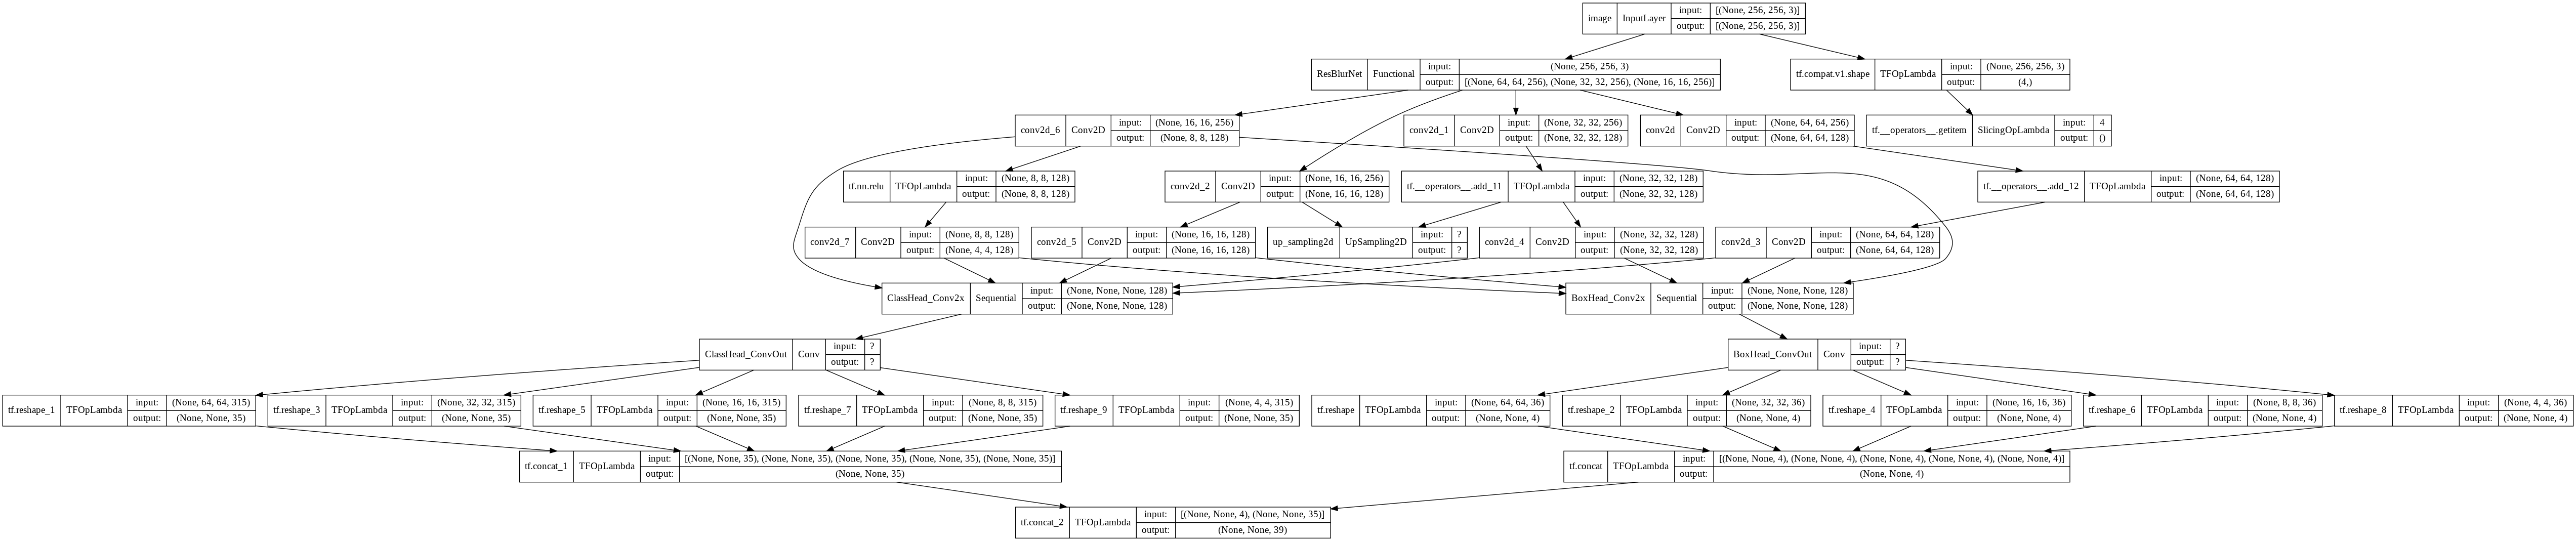

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

#7. Training configuration

##Config saving

In [ ]:
training_config = {
    "image_input": image_input_shape,
    "label_input": label_input_shape,
    "batch_size": batch_size,
    "train_epoch_size": train_epoch_size,
    "val_epoch_size": val_epoch_size,
    "max_text_blocks": max_text_blocks,
    "text_min_len": text_min_len,
    "text_max_len": text_max_len,
    "font_size": font_size,
    "model_characters": model_characters,
    "num_model_characters": len(model_characters),
    "generator_characters": train.generator_characters.tolist(),
    "replace_dict": train.replace_dict,
    "learning_rate": learning_rate,
    "num_features": num_features,
    "max_features": max_features,
    "num_feature_blocks": num_feature_blocks,
    "num_blocks": num_blocks,
    "layers_per_level": layers_per_level,
    "fpn_out_features": fpn_out_features,
    "pred_head_layers": pred_head_layers,
    "residual_needed": residual_needed,
    "kernel_size": kernel_size,
    "strides": strides,
    "activation": activation,
    "batchnorm_needed": batchnorm_needed,
    "dropout": dropout,
    "model_name": model_name,
    "realm": realm
}

with open(f"{training_dir}config.json", 'w', encoding='UTF-8') as f:
    json.dump(training_config, f, ensure_ascii=False, indent=4)

with open(f'{training_dir}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

##General parameters, general callbacks

In [ ]:
epochs = 100

# Early stopping configuration
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=early_stopping_patience, 
    verbose=1, 
    restore_best_weights=True)

# Save model checkpoint configuration
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss", 
    mode="auto", 
    filepath=checkpoint_dir, 
    verbose=1, 
    save_weights_only=True, 
    save_best_only=True)

# TensorBoard configuration
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    profile_batch=2,
    histogram_freq=1,
    embeddings_freq=0,
    write_graph=False,
    update_freq="epoch")

##Specific callbacks

In [ ]:
# Learning rate scheduler
n_epochs_before_lr_decrease = 10
# Keep the initial learning rate for the first n_epochs_before_lr_decrease and decrease exponentially after that
def lr_schedule(epoch, lr):
    if epoch < n_epochs_before_lr_decrease:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Reduce learning rate on plateau configuration
on_plateau_patience = 5
on_plateau_min_delta = 0.0001
on_plateau_min_lr = 1e-5
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.2, 
    patience=on_plateau_patience, 
    verbose=1, 
    mode="auto", 
    min_delta=on_plateau_min_delta, 
    cooldown=0, 
    min_lr=on_plateau_min_lr
)

#8. Training

##TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
print(log_dir)
print(hyperopt_logs_dir)

/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20211104-231445/training/logs/
/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20211104-231445/hyperopt/logs/


In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20211104-231445/training/logs/"

##A: Single training

In [ ]:
#Train the model
training_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    # to plot training countinously in TensorBoard, set it to the value trained SO FAR when loading & training a model further
    initial_epoch=0,
    epochs=epochs,
    callbacks=[early_stopping, save_checkpoint, tensorboard_callback]
)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 371.9656
Epoch 00001: val_loss improved from inf to 165.33487, saving model to /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20211119-092729/training/checkpoint/
1250/1250 [==============================] - 1812s 1s/step - loss: 371.9656 - val_loss: 165.3349
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 97.8042
Epoch 00002: val_loss improved from 165.33487 to 61.25202, saving model to /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20211119-092729/training/checkpoint/
1250/1250 [==============================] - 1802s 1s/step - loss: 97.8042 - val_loss: 61.2520
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 39.4096
Epoch 00003: val_loss improved from 61.25202 to 36.59457, saving model to /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20211119-092729/tra

In [ ]:
best_loss = min(training_history.history["val_loss"])
n_epoch_trained = 0
print(best_loss)

##B: Hyperopt project

### Specify constants & variables with ranges

In [ ]:
hp = HyperParameters()

# constants
hp.Fixed(name='img_dim_0', value=50)
hp.Fixed(name='img_dim_1', value=500)
hp.Fixed(name='in_channel', value=1)
hp.Fixed(name='num_characters', value=37)
hp.Fixed(name='stride', value=1)
hp.Fixed(name='learning_rate', value=1e-3)
# variables
hp.Choice(name='num_features', values=[8, 16, 32, 64])
hp.Choice(name='kernel_size', values=[3, 5])
hp.Choice(name='activation', values=["relu", "elu", "tanh"])
hp.Boolean(name='residual_needed', default=True)
hp.Boolean(name='batchnorm_needed', default=True)
hp.Float(name='dropout', min_value=0, max_value=0.6, step=None, sampling='linear', default=0.1)
hp.Int(name='num_blocks', min_value=1, max_value=3, step=1, default=2)
hp.Int(name='layers_per_level', min_value=1, max_value=4, step=1, default=1)

print(f"Default parameters: {hp.values}")

Default parameters: {'img_dim_0': 50, 'img_dim_1': 500, 'in_channel': 1, 'num_characters': 37, 'stride': 1, 'learning_rate': 0.001, 'num_features': 8, 'kernel_size': 3, 'activation': 'relu', 'residual_needed': True, 'batchnorm_needed': True, 'dropout': 0.1, 'num_blocks': 2, 'layers_per_level': 1}


### Hyperopt project

In [ ]:
print(f"Hyperopt project: {hyperopt_dir}")

Hyperopt project: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20210418-143210/hyperopt/


### Define model builder method

In [ ]:
def model_builder(hp):
    gc.collect()

    img_dim_0 = hp['img_dim_0']
    img_dim_1 = hp['img_dim_1']
    in_channel = hp['in_channel']
    num_characters = hp['num_characters']
    stride = hp['stride']
    learning_rate = hp['learning_rate']
    
    num_features = hp['num_features']
    num_blocks = hp['num_blocks']
    layers_per_level = hp['layers_per_level']
    residual_needed = hp['residual_needed']
    kernel_size = hp['kernel_size']
    activation = hp['activation']
    batchnorm_needed = hp['batchnorm_needed']
    dropout = hp['dropout']

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model = residual_ocr_model(image_dim=(img_dim_0, img_dim_1), in_channel=in_channel, num_characters=num_characters, optimizer=optimizer,
                           num_features=num_features, num_blocks=num_blocks, layers_per_level=layers_per_level, residual_needed=residual_needed,
                           kernel_size=kernel_size, stride=stride, activation=activation, batchnorm_needed=batchnorm_needed, dropout=dropout, name="Residual_OCR")
    return model

### Init tuner

In [ ]:
factor = 7
hyperband_iterations=1

epochs_per_iteration = epochs * (math.log(epochs, factor) ** 2)
all_epochs = math.ceil(epochs_per_iteration * hyperband_iterations)

tuner = kt.tuners.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=epochs,
    factor=factor,
    hyperband_iterations=hyperband_iterations,
    seed=42,
    hyperparameters=hp,
    directory=hyperopt_dir,
    project_name=f"hyperopt"
)
tuner.search_space_summary()
print(f"\nAll epochs: {all_epochs}")
print(f"Hyperopt project root: {hyperopt_dir}")

with open(f'{hyperopt_dir}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20210418-143210/hyperopt/hyperopt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20210418-143210/hyperopt/hyperopt/tuner0.json
Search space summary
Default search space size: 14
img_dim_0 (Fixed)
{'conditions': [], 'value': 50}
img_dim_1 (Fixed)
{'conditions': [], 'value': 500}
in_channel (Fixed)
{'conditions': [], 'value': 1}
num_characters (Fixed)
{'conditions': [], 'value': 37}
stride (Fixed)
{'conditions': [], 'value': 1}
learning_rate (Fixed)
{'conditions': [], 'value': 0.001}
num_features (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'tanh'], 'ordere

In [ ]:
tensorboard_tuner_callback = tf.keras.callbacks.TensorBoard(
    log_dir=hyperopt_logs_dir,
    histogram_freq=1,
    embeddings_freq=0,
    write_graph=False,
    update_freq='epoch')

###Run hyperparameter optimization

In [ ]:
tuner.search(
    x=train_dataset,
    validation_data=validation_dataset,
    # to plot training countinously in TensorBoard, set it to the value trained SO FAR when loading & training a model further
    initial_epoch=0,
    epochs=epochs,
    callbacks=[tensorboard_tuner_callback, early_stopping],
    use_multiprocessing=True
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
img_dim_0         |50                |50                
img_dim_1         |500               |500               
in_channel        |1                 |1                 
num_characters    |37                |37                
stride            |1                 |1                 
learning_rate     |0.001             |0.001             
num_features      |16                |64                
kernel_size       |5                 |3                 
activation        |relu              |elu               
residual_needed   |False             |False             
batchnorm_needed  |True              |True              
dropout           |0.10676           |0.30359           
num_blocks        |2                 |2                 
layers_per_level  |2                 |3                 
tuner/epochs      |3                 |3                 
tuner/initial_e...|0                 |0                 
tune

### Retrieve best configuration so far

In [ ]:
# Get the optimal hyperparameters
optimal_hyparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(optimal_hyparams.values)

tuner.results_summary(3)

{'x': 3, 'y': 4, 'z': 2, 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Results summary
Results in /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/hyperopt/opt_20210413-181502
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
x: 3
y: 4
z: 2
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 39.42935562133789
Trial summary
Hyperparameters:
x: 2
y: 2
z: 3
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 39.764686584472656
Trial summary
Hyperparameters:
x: 4
y: 1
z: 4
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: f93c5f2c0362d31ab097b470c5170e8d
Score: 40.609230041503906


### Retrieve best model(s) so far

In [ ]:
best_models = tuner.get_best_models(num_models=1)
best_models[0].summary()

Model: "Residual_OCR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 50, 500, 1)] 0                                            
__________________________________________________________________________________________________
Permute (Permute)               (None, 500, 50, 1)   0           image[0][0]                      
__________________________________________________________________________________________________
ResBlock1_Conv1x (Sequential)   (None, 500, 50, 32)  416         Permute[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 500, 50, 32)  0           ResBlock1_Conv1x[0][0]           
                                                                 Permute[0][0]         

#9. Evaluation

In [ ]:
loss = model.evaluate(validation_dataset, verbose=2)
print("loss: {:2.4f}".format(loss))

#10. Model I/O

##Save model

In [ ]:
n_epoch_trained = 19
best_loss = 1.46661

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"{model.name}_{current_time}_plate_epoch{n_epoch_trained}_loss{'{0:.4f}'.format(best_loss)}"
model.save(f"{keras_dir}{model_name}")

with open(f"{keras_dir}{model_name}{sep}config.json", 'w', encoding='utf-8') as f:
    json.dump(training_config, f, ensure_ascii=False, indent=4)
with open(f'{keras_dir}{model_name}{sep}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

print(f"Model saved: {model_name}")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/keras/ResBlurDetector_20211118-140453_plate_epoch19_loss1.4666/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/keras/ResBlurDetector_20211118-140453_plate_epoch19_loss1.4666/assets


Model saved: ResBlurDetector_20211118-140453_plate_epoch19_loss1.4666


##Load model

In [ ]:
model_name = f"ResBlurDetector_20211114-224120_plate_epoch7_loss10.1975"
model = keras.models.load_model(f"{keras_dir}{model_name}", compile=False)

with open(f"{keras_dir}{model_name}{sep}config.json") as f:
  training_config = json.load(f)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = RetinaNetLoss(num_classes)
model.compile(loss=loss_fn, optimizer=optimizer)

# Re-evaluate the model
loss = model.evaluate(validation_dataset, verbose=2)
print("Loaded model, loss: {:2.4f}".format(loss))

##Load weights

In [ ]:
# Loads the weights
model.load_weights(checkpoint_dir)

# Re-evaluate the model
#loss = model.evaluate(validation_dataset, verbose=2)
#print("Loaded model, loss: {:2.4f}".format(loss))

In [ ]:
model.summary()

Model: "ResBlurDetector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 ResBlurNet (Functional)        [(None, 64, 64, 256  1575792     ['image[0][0]']                  
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                                
                                 (None, 16, 16, 256                                 

#11. Inference model

>Create the pure prediction model & run inference on it.

##Build prediction model

In [ ]:
prediction_model = None
gc.collect()

image = tf.keras.Input(shape=image_input_shape, name="image")
predictions = model(image, training=False)
detections = OutputDecoder(confidence_thres=0.3, nms_IoU_thres=0.5, max_detections_per_class=100, max_detections=100, name="detections")(image, predictions)

prediction_model = keras.models.Model(inputs=image, outputs=detections)
prediction_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 ResBlurDetector (Functional)   (None, None, 39)     3557484     ['image[0][0]']                  
                                                                                                  
 detections (OutputDecoder)     CombinedNonMaxSuppr  0           ['image[0][0]',                  
                                ession(nmsed_boxes=               'ResBlurDetector[6][0]']        
                                (None, 100, 4),                                             

##Run inference

In [ ]:
def show_inference_results(dataset_wrapper, detector_encoder, model, linewidth=1, box_color="#00ff00"):

    batch_size = dataset_wrapper.batch_size
    img_in_line = 4
    num_lines = dataset_wrapper.batch_size // img_in_line
    img_size_w = 6
    img_size_h = 6

    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))
    
    for images, boxes, classes in dataset_wrapper.dataset.take(1):
        encoded_images = detector_encoder.encode_image(images)

        detections = model.predict(encoded_images)
        #print(detections)

        # if image has only one channel, drop channel dim to plot with matplotlib
        if(images.shape[3] == 1):
            images = images[:,:,:,0]

        for i in range(batch_size):
            num_detections = detections.valid_detections[i]
            detected_boxes = detections.nmsed_boxes[i]
            detected_classes = detections.nmsed_classes[i].astype(int)

            label = "\n" + dataset_wrapper.decode_label(classes[i], drop_oov=False) + " [True]\n"
            if(num_detections > 0):
                label += dataset_wrapper.decode_label(detected_classes[:num_detections], False) + " [Pred]"

            ax[i // img_in_line, i % img_in_line].imshow(images[i])
            ax[i // img_in_line, i % img_in_line].set_title(label)

            for box in detected_boxes[:num_detections]:
                #print(box)
                x_min, y_min, x_max, y_max = box
                img_h = dataset_wrapper.image_dim[0]
                img_w = dataset_wrapper.image_dim[1]
                x_min *= img_w
                x_max *= img_w
                y_min *= img_h
                y_max *= img_h
                min_xy = (x_min, y_min)
                width = (x_max-x_min)
                height = (y_max-y_min)
                rect = patches.Rectangle(min_xy, width, height, linewidth=linewidth, edgecolor=box_color, facecolor='none')
                ax[i // img_in_line, i % img_in_line].add_patch(rect)

    plt.show()

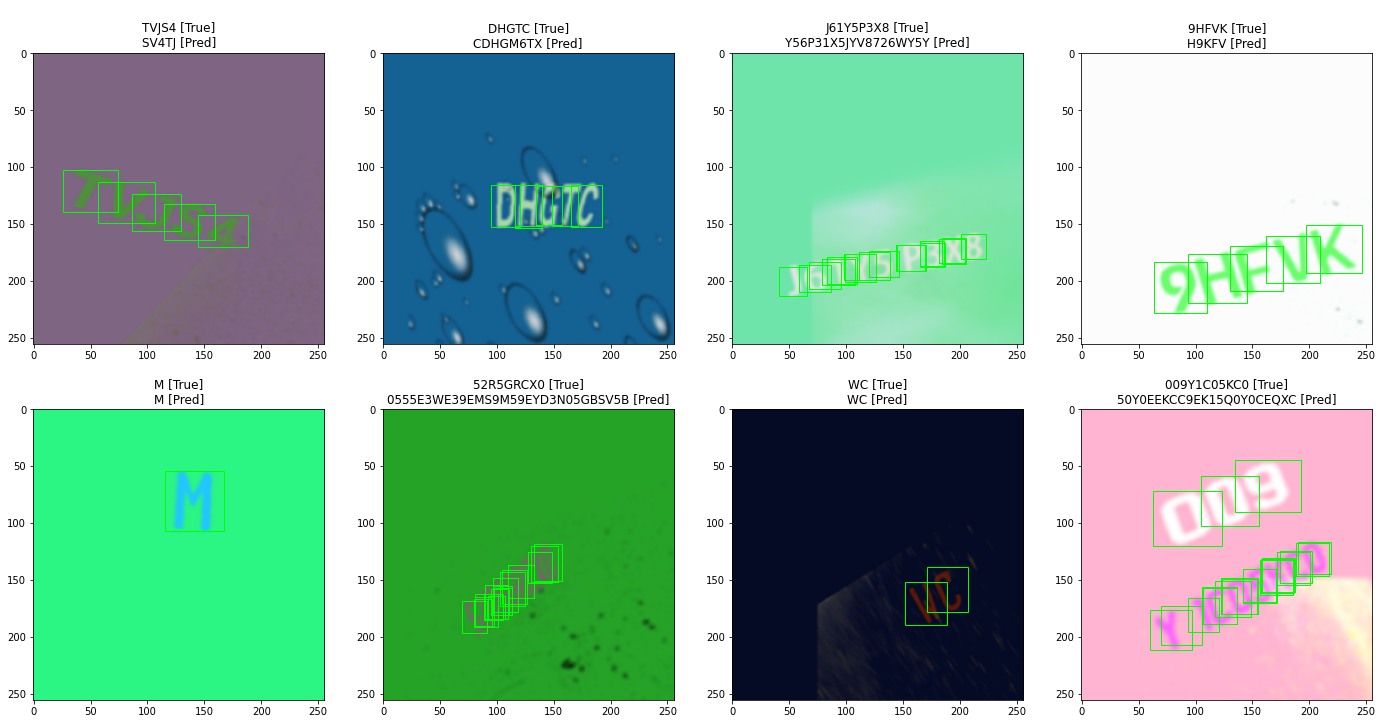

In [ ]:
show_inference_results(validation, DetectorEncoder(), prediction_model)

#12. TFLite conversion

##Define source model, create individual tmp model

In [ ]:
model_name = f"ResBlurDetector_20211118-140453_plate_epoch19_loss1.4666"

# Save the pure prediction model to model_tmp_dir before the tflite conversion
#source_model = keras.models.load_model(f"{keras_dir}{model_name}")
source_model = prediction_model

#with open(f"{keras_dir}{model_name}{sep}config.json") as f:
#  config = json.load(f)
config = training_config

target_model = keras.models.Model(source_model.get_layer(name="image").input, source_model.get_layer(name="detections").output)
print(target_model.get_layer(name="image").input)

# set constant shapes to have Android tflite GPU interpreter support
target_model.input.set_shape((1, 256, 256, 3))
print(target_model.get_layer(name="image").input)
print(target_model.get_layer(name="detections").output)

target_model.save(model_tmp_dir)
source_model = None
target_model = None
gc.collect()

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256, 3), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
CombinedNonMaxSuppression(nmsed_boxes=<KerasTensor: shape=(None, 100, 4) dtype=float32 (created by layer 'detections')>, nmsed_scores=<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'detections')>, nmsed_classes=<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'detections')>, valid_detections=<KerasTensor: shape=(None,) dtype=int32 (created by layer 'detections')>)


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tmp/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tmp/assets


248389

##Convert to tflite

>Note: Some layers have quantization issues due to a Tensorflow bug so full-integer quantization cannot be done at the moment (reason of uncommented lines). Dynamic range quantization is used, which reduces the size of the model to 1/4.

In [ ]:
def representative_dataset():
    
     for images, labels in train_dataset.take(100):
         # to return shape=(batch_size x img) array
         #image = images

         # to return shape=(1 x img) array
         image = tf.expand_dims(images[0], axis=0)

         yield image

(1, 256, 256, 3)


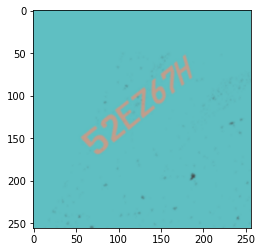

In [ ]:
img = next(representative_dataset())

print(img.shape)
img = DetectorEncoder().decode_image(img[0])

# if image has only one channel, drop channel dim to plot with matplotlib
if(img.shape[2] == 1):
    img = img[:,:,0]
imgplot = plt.imshow(img)
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_tmp_dir)
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True

#Dynamic integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

#Full integer quantization
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
#converter.representative_dataset = representative_dataset

tflite_model = converter.convert()
target_file_dir = f"{tflite_dir}{model_name}{sep}"
target_file_path = f"{target_file_dir}model.tflite"

if not os.path.exists(target_file_dir):
    os.makedirs(target_file_dir)

# Save the tflite model
with open(target_file_path, 'wb') as f:
  f.write(tflite_model)
  print(f"Model saved successfully to {target_file_path}")

with open(f"{target_file_dir}config.json", 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)
with open(f'{target_file_dir}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

Model saved successfully to /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tflite/ResBlurDetector_20211118-140453_plate_epoch19_loss1.4666/model.tflite


##TFLite model details

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
#interpreter = tf.lite.Interpreter(model_path=f"{tflite_dir}model.tflite")

# Get input and output tensors
input = interpreter.get_input_details()
input_type = [interpreter.get_input_details()[i]['dtype'] for i in range(len(input))]
input_shape = [input[i]['shape'] for i in range(len(input))]
input_idx = [input[i]['index'] for i in range(len(input))]

output = interpreter.get_output_details()
output_type = [interpreter.get_output_details()[i]['dtype'] for i in range(len(output))]
output_shape = [output[i]['shape'] for i in range(len(output))]
output_idx = [output[i]['index'] for i in range(len(output))]

print('input: ', input)
print('type: ', input_type)
print('shape: ', input_shape)
print('index: ', input_idx)
print()
print('output: ', output)
print('type: ', output_type)
print('shape: ', output_shape)
print('index: ', output_idx)

input:  [{'name': 'serving_default_image:0', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
type:  [<class 'numpy.float32'>]
shape:  [array([  1, 256, 256,   3], dtype=int32)]
index:  [0]

output:  [{'name': 'StatefulPartitionedCall:3', 'index': 249, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:2', 'index': 248, 'shape': array([  1, 100], dtype=int32), 'shape_signature': array([  1, 100], dtype=int32), 'dtype': <class 

##TFLite model inference

(1, 256, 256, 3)


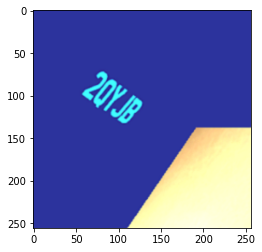

In [ ]:
# Generate random input image to test the model
random_input = next(representative_dataset())
#random_input = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print(random_input.shape)
random_input_plottable = DetectorEncoder().decode_image(random_input[0])

# if image has only one channel, drop channel dim to plot with matplotlib
if(random_input_plottable.shape[2] == 1):
    random_input_plottable = random_input_plottable[:,:,0]
imgplot = plt.imshow(random_input_plottable)
plt.show()

In [ ]:
interpreter.allocate_tensors()

# Test the model on random input data
interpreter.set_tensor(input_idx[0], random_input)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data
# Use `tensor()` in order to get a pointer to the tensor
output_data = [interpreter.get_tensor(i) for i in output_idx]
print(output_data)